# **IMPLEMENTATION OF EDDYSED CODE**
This code is very closely mapped to the eddysed code of Ackerman and Marley from Original Fortran to my implemented Python Version.



### Import necessary python modules


In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Global constants


In [73]:
""" This module defines physical and mathematical constants for atmospheric modeling. Careful for the units! """

MAXNZ = 50 # maximum number of layers
R_Gas = 8.3145e7 # Universal gas constant erg/(K mol)
StefBoltz = 5.6704e-5 # Stefan-Boltzmann constant erg/(cm^2 s K^4)
Avogadro = 6.02214179e23 # Avogadro's number molecules/mol
k_Boltz = 1.38064852e-16 # Boltzmann constant erg/K
Pi = np.pi

# Implementation of read_voyager.f
This code snippet talks about the way the input file from voyager_inputs in the main eddysed code has been handled.


In [74]:
def read_voyager(input_file):

    """
    The input file from voyager_inputs in the main eddysed code.
    reads the following inputs:
    Pressure 
    Temperature
    Gravity
    Effective Temperature
    Number of layers edges

    It calculates the number of layers , effective convective heat flux (chf), 
    molecular weight of atmosphere (assumed constant at 2.2 g/mol), and builds the T and P layers and sub layers along with the creation of altitude layers (Z) and its sub layers.


    and returns the following outputs:

    gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, num_layers,  p_layers, t_layers, z_layers, chf
    """

    input_data = []
    with open(input_file, "r") as f:
        lines = f.readlines()
        T_eff = float(lines[0])+0.5
        gravity = ((float(lines[1]))/100)+0.5
        num_layer_edges = int(lines[2])
        num_layers = num_layer_edges - 1
        for line in lines[4:]:
            parts = line.strip().split()
            input_data.append([float(x.replace("E", "e")) for x in parts])
    input_array = np.array(input_data)
    t_layer_edges = input_array[:, 0]
    p_layer_edges = input_array[:, 1]

    r_atmos = 8.3145e7/2.2

    z_layer_edges = np.zeros(num_layer_edges)
    z_layers = np.zeros(num_layers)
    p_layers = np.zeros(num_layers)
    t_layers = np.zeros(num_layers)

    for i in range(num_layers-1, -1, -1):
        itop = i
        ibot = i + 1
        dlnp = np.log(p_layer_edges[ibot]/p_layer_edges[itop])
        p_layers[i] = (p_layer_edges[itop] + p_layer_edges[ibot]) / 2
        scale_height = r_atmos * t_layer_edges[ibot] / gravity
        dz_layer = scale_height * dlnp
        z_layer_edges[i] = z_layers[ibot-1] + dz_layer
        dtdz = (t_layer_edges[itop] - t_layer_edges[ibot]) / dz_layer
        dz_pmid = scale_height * np.log(p_layer_edges[ibot]/p_layers[i])
        z_layers[i] = z_layer_edges[ibot] + dz_pmid
        t_layers[i] = t_layer_edges[ibot] + dtdz * dz_pmid

    chf = StefBoltz * T_eff**4 * np.ones(num_layers) #eqn 21 of Virga Paper where F_rad is assumed to be 0 in convective region

    return gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, num_layers,  p_layers, t_layers, z_layers, chf

# Read Voyager_lh
This snippet takes the input to run eddysed_lh function

In [75]:
def read_voyager_lh(input_file):

    """
    The input file from voyager_inputs in the main eddysed code.
    reads the following inputs:
    Pressure 
    Temperature
    Gravity
    Effective Temperature
    Number of layers edges

    It calculates the number of layers , effective convective heat flux (chf), 
    molecular weight of atmosphere (assumed constant at 2.2 g/mol), and builds the T and P layers and sub layers along with the creation of altitude layers (Z) and its sub layers.


    and returns the following outputs:

    gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, num_layers,  p_layers, t_layers, z_layers, chf, dlnp_layers, lapse_ratio
    """

    input_data = []
    with open(input_file, "r") as f:
        lines = f.readlines()
        T_eff = float(lines[0])
        gravity = float(lines[1])
        num_layer_edges = int(lines[2])
        num_layers = num_layer_edges - 1
        for line in lines[4:]:
            parts = line.strip().split()
            input_data.append([float(x.replace("E", "e")) for x in parts])
    input_array = np.array(input_data)
    t_layer_edges = input_array[:, 0]
    p_layer_edges = input_array[:, 1]

    r_atmos = 8.3145e7/2.2

    z_layer_edges = np.zeros(num_layer_edges)
    z_layers = np.zeros(num_layers)
    p_layers = np.zeros(num_layers)
    t_layers = np.zeros(num_layers)
    scale_h = np.zeros(num_layers)
    dlnp_layers = np.zeros(num_layers)
    lapse_ratio = np.zeros(num_layers)

    for i in range(num_layers-1, -1, -1):
        itop = i
        ibot = i + 1
        dlnp = np.log(p_layer_edges[ibot]/p_layer_edges[itop])
        dlnp_layers[i] = dlnp
        p_layers[i] = (p_layer_edges[itop] + p_layer_edges[ibot]) / 2
        scale_height = r_atmos * t_layer_edges[ibot] / gravity
        scale_h[i] = scale_height
        dz_layer = scale_height * dlnp
        z_layer_edges[i] = z_layers[ibot-1] + dz_layer
        dtdz = (t_layer_edges[itop] - t_layer_edges[ibot]) / dz_layer
        dz_pmid = scale_height * np.log(p_layer_edges[ibot]/p_layers[i])
        z_layers[i] = z_layer_edges[ibot] + dz_pmid
        t_layers[i] = t_layer_edges[ibot] + dtdz * dz_pmid
        c_p_factor = 7/2
        lapse_ratio[i] = ( t_layer_edges[ibot] - t_layer_edges[itop] ) / dlnp / ( t_layers[i] / c_p_factor )

    chf = StefBoltz * T_eff**4 * np.ones(num_layers) #eqn 21 of Virga Paper where F_rad is assumed to be 0 in convective region

    return gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, num_layers,  p_layers, t_layers, z_layers, chf, dlnp_layers, lapse_ratio

# Implementation of pvap_gas.f
Here the pressure vapour pressure exerted by the condensate is found in the atmosphere of the planet.


In [76]:
def pvap_gas(gas_name, t_layer,p_layer):
    """ 
    Here we are finding the e_s value for the clasius claperyon equation which is given in A1 eqn of Appendix A in AM01
    the input temperature is in Kelvin.

    Input : Gas name

    Output : e_s value
    """
    if gas_name == "NH3":
        pvap_nh3 = np.exp(-86596/t_layer**2 - 2161/t_layer +10.53)# in dyne/cm^2
        
        return np.array (pvap_nh3 )
    else:
        raise ValueError("Gas not recognized in pvap_gas function.")

# Implementation of advdiff.f
This snippet contains the main cloud equation of Ackerman and Marley. The equation talks about the balance between advective and convective current of mixing f molecules.
This function needs to call the v_fall function to pass arguments through it.


In [77]:
def advdiff(qt, ad_qbelow, ad_qvs, ad_mixl, ad_dz, ad_fsed):
    """
    calculate divergence from advective-diffusive balance for condensate in a model layer
    Units are in cgs:
    input parameter passed through argument list :
    
    qt      :        total mixing ratio of condensate + vapor (g/g)

    input parameters which are called into the v_fall function:

    ad_qbelow    :   total mixing ratio of vapor in underlying layer (g/g)
    ad_qvs      :    saturation mixing ratio (g/g)
    ad_mixl     :    convective mixing length (cm)
    ad_dz       :    layer thickness (cm) 
    ad_rainf     :   rain efficiency factor 


    Output parameters that come through the v_fall function :

    ad_qc     :      mixing ratio of condensed condensate (g/g)

    """
    ad_qc = max(0.0, qt - ad_qvs) # q_t(z) = q_v(z-dz) paragraph below eqn 1 of AMO1,section 2.1, here instead of q_v , q_t is used as it is used to give a more inclusive approach to suite the entire cloud formation dynamics for more details read the paragraph below figure -1 
    advdiff = ad_qbelow * np.exp(-ad_fsed * ad_qc * ad_dz / (qt*ad_mixl)) - qt # eqn 4 of AM01
    
    return advdiff
    

# Implementation of find_root.f
This snippet finds convergence solution between two points which are very close tp each other using the secant method.


In [78]:
def find_root(f, y, params, xlow, xhigh, delta):
    """
    Find solution to f(x, *params) - y = 0 using a Brent-Dekker style algorithm.

    This is a robust hybrid of bisection, secant and inverse-quadratic
    interpolation. It requires that the initial interval [xlow, xhigh]
    brackets a root (f(xlow)-y and f(xhigh)-y have opposite signs).

    Inputs:
      f : callable f(x, *params)
      y : scalar target
      params : tuple of extra parameters passed to f
      xlow, xhigh : bracket for the root (must bracket the root)
      delta : tolerance on the function value (absolute)

    Returns:
      xroot : estimated root
      status: 0 success, 1 max iterations reached, -1 bracket failure or evaluation error
    """
    max_iter = 100
    tol_x = 1e-12

    a = xlow
    b = xhigh

    try:
        fa = f(a, *params) - y
        fb = f(b, *params) - y
    except Exception:
        return xlow, -1

    if not np.isfinite(fa) or not np.isfinite(fb):
        return xlow, -1

    if fa * fb > 0:
        # no sign change -> cannot use bracketing method
        return xlow, -1

    # Ensure that |f(a)| >= |f(b)| so that b is the best root estimate
    if abs(fa) < abs(fb):
        a, b = b, a
        fa, fb = fb, fa

    c = a
    fc = fa
    d = b - a
    e = d

    for it in range(max_iter):
        if fb == 0 or abs(b - a) < tol_x * max(abs(b), 1.0):
            return b, 0

        # Attempt interpolation if possible
        if fa != fc and fb != fc:
            # Inverse quadratic interpolation
            try:
                s = (a * fb * fc) / ((fa - fb) * (fa - fc)) + \
                    (b * fa * fc) / ((fb - fa) * (fb - fc)) + \
                    (c * fa * fb) / ((fc - fa) * (fc - fb))
            except Exception:
                s = None
        else:
            # Secant method
            if fb - fa != 0:
                s = b - fb * (b - a) / (fb - fa)
            else:
                s = None

        use_bisect = False
        if s is None or not np.isfinite(s):
            use_bisect = True
        else:
            # Conditions to accept interpolation (from Brent's method)
            if ( (s < (3*a + b) / 4.0) or (s > b) ):
                use_bisect = True
            if (e is not None) and (abs(s - b) >= abs(b - c) / 2.0):
                use_bisect = True
            if (e is not None) and (abs(b - c) < tol_x * max(abs(b), 1.0)):
                use_bisect = True

        if use_bisect:
            s = 0.5 * (a + b)
            e = d
            d = b - s
        else:
            d = b - s
            e = d

        # Evaluate at s
        try:
            fs = f(s, *params) - y
        except Exception:
            return b, -1

        # Update a, b, c to maintain the bracket with opposite signs
        c = a
        fc = fa
        if fa * fs < 0:
            b = s
            fb = fs
        else:
            a = s
            fa = fs

        # Make sure that |f(a)| >= |f(b)|
        if abs(fa) < abs(fb):
            a, b = b, a
            fa, fb = fb, fa

    return b, 1


# Implementation of v_fall.f
This code calculates the fallspeed for a spherical particle at one layer of the atmosphere depending on the Reynolds number for Stokes flow.

In [79]:
def vfall(r, vf_grav, vf_mw_atmos, vf_mfp, vf_visc, vf_t, vf_p, vf_rhop):
    """
    calculate fallspeed for a spherical particle at one layer in an
   atmosphere, depending on Reynolds number for Stokes flow.
    For Re_Stokes < 1, use Stokes velocity with slip correction
    For Re_Stokes > 1, use fit to Re = exp( b1*x + b2*x^2 )
     where x = log( Cd Re^2 / 24 )
     where b2 = -0.1 (curvature term) and 
     b1 from fit between Stokes at Re=1, Cd=24 and Re=1e3, Cd=0.45

     
     all units are cgs

    input parameters:
     r : particle radius (cm)

    input parameters through vfall function :
     vf_grav   :     acceleration of gravity (cm/s^2)
     vf_mw_atmos :   atmospheric molecular weight (g/mol)
     vf_mfp    :     atmospheric molecular mean free path (cm)
     vf_visc   :     atmospheric dynamic viscosity (dyne s/cm^2)
     vf_t     :      atmospheric temperature (K)
     vf_p     :      atmospheric pressure (dyne/cm^2)
     vf_rhop  :      density of particle (g/cm^3)

    output : the quantities passed through vfall function

    """
    b1 = 0.8          # Ackerman
    # b1 = 0.86       # Rossow
    # b1 = 0.72       # Carlson
    b2 = -0.01
    cdrag = 0.45      # Ackerman
    # cdrag = 0.2     # Rossow
    # cdrag = 2.0     # Carlson
    
    # calculate vfall based on Knudsen and Reynolds number
    knudsen = vf_mfp / r
    rho_atmos = vf_p / ((R_Gas / vf_mw_atmos) * vf_t)
    drho = vf_rhop - rho_atmos

    # Cunningham correction (slip factor for gas kinetic effects)
    slip = 1 + 1.26*knudsen 

    # Stokes terminal velocity (low Reynolds number)
    vfall = slip*(2/9) * drho * vf_grav * r**2 / vf_visc #B1 of AMO1
    reynolds = 2 * r* rho_atmos * vfall / vf_visc # Paragraph after B2

    if reynolds > 1:

        # correct drag coefficient for turbulence (Re = Cd Re^2 / 24)
        x = np.log(reynolds)
        y = b1*x + b2*x**2
        reynolds = np.exp(y)
        vfall = vf_visc*reynolds / (2 * r * rho_atmos)

        if reynolds > 1000:
            # drag coefficient independent of Reynolds number
            vfall = slip * np.sqrt(8 * drho * r * vf_grav / (3 * cdrag * rho_atmos)) #B3 of AM01

    return vfall

# Implementation of qvs_below.f
This snippet deals with finding the first saturation vapour mixing value for the layer edge (refer to eqn 7 of AM01).

In [80]:
def qvs_below(p_test, qv_dtdlnp, qv_p, qv_t, qv_factor, qv_gas_name):
    """
    Calculate q_vs below  for a gas
    Input :
    p_test : test pressure
    t_test : test temperature
    qv_p  : vapour mixing pressure
    qv_t : vapour mixing temperature
    qv_factor : gas_mw /mw_atmos (assuming supersat =0)
    qv_gas_name : Name of the gas

    output :
    qvs_below : saturation mixing ratio for the first layer edge
    """
    # Extrapolate temperature lapse ratio to test pressure
    t_test = qv_t + np.log(qv_p / p_test) * qv_dtdlnp

    # Compute saturation mixing ratio
    pvap_test = pvap_gas(qv_gas_name, t_test, p_test)
    qvs_below = qv_factor * pvap_test / p_test

    return qvs_below
   

# Implementation of find_rootl.f
This function deals with the find_root in logarithm scale

In [81]:
def find_rootl(f, y, params, xlow, xhigh, delta):
    """
    Find solution to log(f(x)) - log(y) = 0 using Brent-style root finder on g(x)=log(f)-log(y).

    This function evaluates f(x) and forms g(x). It requires f(x) > 0 inside the bracket.

    Returns same status codes as find_root.
    """
    # wrapper g(x) = log(f(x)) - log(y)
    def g(x, *p):
        fx = f(x, *p)
        if fx <= 0 or not np.isfinite(fx):
            # return a non-finite number; caller will handle sign check
            return np.nan
        return np.log(fx) - np.log(y)

    # initial checks
    try:
        gv_low = g(xlow, *params)
        gv_high = g(xhigh, *params)
    except Exception:
        return xlow, -1

    if not np.isfinite(gv_low) or not np.isfinite(gv_high):
        return xlow, -1

    if gv_low * gv_high > 0:
        return xlow, -1

    # Use the same Brent-style routine as find_root but on g
    max_iter = 100
    tol_x = 1e-12

    a = xlow
    b = xhigh
    fa = gv_low
    fb = gv_high

    # Ensure |fa| >= |fb|
    if abs(fa) < abs(fb):
        a, b = b, a
        fa, fb = fb, fa

    c = a
    fc = fa
    d = b - a
    e = d

    for it in range(max_iter):
        if fb == 0 or abs(b - a) < tol_x * max(abs(b), 1.0):
            return b, 0

        # interpolation on g
        if fa != fc and fb != fc:
            try:
                s = (a * fb * fc) / ((fa - fb) * (fa - fc)) + \
                    (b * fa * fc) / ((fb - fa) * (fb - fc)) + \
                    (c * fa * fb) / ((fc - fa) * (fc - fb))
            except Exception:
                s = None
        else:
            if fb - fa != 0:
                s = b - fb * (b - a) / (fb - fa)
            else:
                s = None

        use_bisect = False
        if s is None or not np.isfinite(s):
            use_bisect = True
        else:
            if (s < (3*a + b) / 4.0) or (s > b):
                use_bisect = True
            if (e is not None) and (abs(s - b) >= abs(b - c) / 2.0):
                use_bisect = True
            if (e is not None) and (abs(b - c) < tol_x * max(abs(b), 1.0)):
                use_bisect = True

        if use_bisect:
            s = 0.5 * (a + b)
            e = d
            d = b - s
        else:
            d = b - s
            e = d

        try:
            gv_s = g(s, *params)
        except Exception:
            return b, -1

        if not np.isfinite(gv_s):
            return b, -1

        c = a
        fc = fa
        if fa * gv_s < 0:
            b = s
            fb = gv_s
        else:
            a = s
            fa = gv_s

        if abs(fa) < abs(fb):
            a, b = b, a
            fa, fb = fb, fa

    return b, 1


# Implementation of calc_qc.f

This code snippet is about the implementation of the calc_qc function where the condensate mixing ratio is calculated and r_g and r_eff and number of droplet concentration is also calculated

This function requires to call the find_root, v_fall and advdiff to be called in to be executed properly.

In [82]:
def calc_qc(gas_name, f_sed_layer, rho_p, mw_cloud, q_below, supsat, w_convect, mixl, dz_layer, gravity, mw_atmos, mfp, visc, t_layer, p_layer, sig_layer):

    """
    Calculate the condensate mixing ratio and the total mixing ratio along with the droplet effective and geometric mean radius along with coloumn droplet number concentration in a single atmospheric layer 
    """

    pvap = pvap_gas(gas_name, t_layer, p_layer)
    fs = supsat + 1
    rho_atmos = p_layer / (R_Gas/mw_atmos * t_layer)
    qvs = fs * pvap / (R_Gas/mw_cloud * t_layer) / rho_atmos

    # Layer is cloud free
    if q_below <= qvs:
        qt_layer = q_below
        qt_top = q_below
        qc_layer = 0.0
        rg_layer = 0.0
        reff_layer = 0.0
        ndz_layer = 0
        status_q = 0
        status_r = 0

    # Layer has cloud
    else:
        qhigh = q_below
        qlow = qhigh * 0.001
        delta_q = q_below *0.001

        # load paramaters into advdiff common block
        ad_qbelow = q_below
        ad_qvs = qvs
        ad_mixl = mixl
        ad_dz = dz_layer
        ad_fsed = f_sed_layer
        params = (ad_qbelow, ad_qvs, ad_mixl, ad_dz, ad_fsed)

        # Find total condensate mixing ratio at the top of the layer
        qt_top, status_q = find_root(advdiff, 0.0, params, qlow, qhigh, delta_q)

        # Use trapezoid rule to calculate layer averages
        qt_layer = 0.5 * (q_below + qt_top)

        # Diagnose condensate mixing ratio
        qc_layer = max(0.0, qt_layer - qvs)

        # Find rw corresponding to w_convect using function vfall()
        vf_grav = gravity
        vf_mw_atmos = mw_atmos
        vf_mfp = mfp
        vf_visc = visc
        vf_p = p_layer
        vf_t = t_layer
        vf_rhop = rho_p
        vf_params = (vf_grav, vf_mw_atmos, vf_mfp, vf_visc, vf_t, vf_p, vf_rhop)

        # range of particle radii to search (cm)
        rlow = 1e-10
        rhigh = 10

        # precision of terminal velocity solution (cm/s)
        delta_v = max(1e-12, abs(w_convect) / 1000)
        rw_layer, status_r = find_root(vfall, w_convect, vf_params, rlow, rhigh, delta_v)

        # default safe output
        rg_layer = 0.0
        reff_layer = 0.0
        ndz_layer = 0

        # check rw validity
        if status_r == 0 and np.isfinite(rw_layer) and (rw_layer > 0):
            # geometric std dev of lognormal size distribution
            try:
                lnsig2 = 0.5 * (np.log(sig_layer))**2
            except Exception:
                lnsig2 = 0.0

            # sigma floor  for the purpose of alpha calculation
            sig_alpha = max(1.1, sig_layer)

            # compute alpha robustly
            alpha = None
            try:
                if f_sed_layer > 1:
                    v_val = vfall(rw_layer * sig_alpha, *vf_params)
                    if v_val <= 0 or not np.isfinite(v_val):
                        alpha = None
                    else:
                        denom = np.log(sig_alpha)
                        alpha = np.log(v_val / w_convect) / denom if denom != 0 else None
                else:
                    v_val = vfall(rw_layer / sig_alpha, *vf_params)
                    if v_val <= 0 or not np.isfinite(v_val):
                        alpha = None
                    else:
                        denom = np.log(sig_alpha)
                        alpha = np.log(w_convect / v_val) / denom if denom != 0 else None
            except Exception:
                alpha = None

            # fallback if alpha is degenerate
            if (alpha is None) or (not np.isfinite(alpha)) or (alpha == 0):
                # set a conservative fallback for alpha
                alpha = 1.0

            # limit exponent magnitude to avoid overflow
            try:
                exponent = 1.0 / alpha
                if not np.isfinite(exponent) or abs(exponent) > 100:
                    exponent = np.sign(exponent) * 100 if exponent != 0 else 1.0
            except Exception:
                exponent = 1.0

            # compute geometric mean radius safely
            try:
                rg_candidate = (f_sed_layer ** exponent) * rw_layer * np.exp(-(alpha + 6) * lnsig2)
                if np.isfinite(rg_candidate) and (rg_candidate > 0):
                    rg_layer = rg_candidate
                    reff_layer = rg_layer * np.exp(5 * lnsig2)
                    # Column droplet number concentration (cm^-2)
                    denom = (4.0 * Pi * rho_p * (rg_layer**3)) * np.exp(-9 * lnsig2)
                    if denom != 0 and np.isfinite(denom):
                        ndz_layer = 3.0 * rho_atmos * qc_layer * dz_layer / denom
                    else:
                        ndz_layer = 0
                else:
                    rg_layer = 0.0
                    reff_layer = 0.0
                    ndz_layer = 0
            except Exception:
                rg_layer = 0.0
                reff_layer = 0.0
                ndz_layer = 0
        else:
            # invalid rw: leave rg/reff/ndz as zeros
            rg_layer = 0.0
            reff_layer = 0.0
            ndz_layer = 0

    return qc_layer, qt_layer, rg_layer, reff_layer, ndz_layer, qt_top, status_r, status_q

# Implementation of layer.f

This code snippet works on the layer function of the code and calculates optical depth until a convergent solution to it is found.
This code snippet works on the layer function of the code and calculates optical depth until a convergent solution to it is found. The kz is also calculated using the Gierasch & Conrath formula over her itself

This function calls in the calc_qc function to be executed properly.


In [83]:
def layer(nsub_max, gas_name, kz_min, cloudf_min, mw_cloud, mw_atmos, f_sed, rho_p, supsat, sig_layer, t_layer, p_layer, t_top, t_bot, p_top, p_bot, chf_layer, gravity, q_below, report_status_r, report_status_q):

    """ 
    Calculating layer condensate properties by iterating on optical depth until converges in one model layers (convergence on optical depth in sublayers)

    Inputs :
    nsub_max :   maximum number of sublayers for mesh refinement
    gas_name  :  name of condensing vapor
    kz_min :     minimum eddy diffusion coefficient (cm^2/s)
    cloudf_min :  minimum cloud fractional coverage
    mw_cloud  :  molecular weight of condensate (g/mol)
    rainf  :     rain factor
    rho_p  :     density of condensed vapor (g/cm^3)
    supsat  :    fractional supersaturation persisting after condensation
    sig_layer :   geometric std deviation of lognormal size distribution
    t_layer :    temperature at layer mid-pt (K)
    p_layer :    pressure at layer mid-pt (dyne/cm^2)
    t_top,bot :  temperature at top and bottom of layer (K)
    p_top,bot :  pressure at top and bottom of layer (dyne/cm^2)
    chf_layer : convective heat flux at the layer
    gravity :  gravity of the planet
    q_below : first layer edge saturation vapour pressure
    

    Outputs :
    qc_layer :   condensate mixing ratio (g/g)
    qt_layer  :  gas + condensate mixing ratio (g/g)
    rg_layer  :  geometric mean radius of condensate (cm)
    reff_layer : effective (area-weighted) radius of condensate (cm)
    ndz_layer  : column of particle concentration in layer (#/cm^2)
    opd_layer :  optical depth for conservative geometric scatterers

    report_status_r :   report error status for finding rw
    report_status_q :   report error status for finding qt

    This function .44668calls calc_qc to calculate the condensate mixing ratio and other properties in the layer by subdividing the layer into sublayers and iterating until convergence on optical depth is achieved.



    """

    # Set error return codes to zero
    status_r = 0
    status_q = 0

    # Number of levels of grid refinement used 
    nsub = 1

    # diameter of atmospheric molecule (cm) (Rosner, 2000)
    # (3.711e-8 for air, 3.798e-8 for N2, 2.827e-8 for H2)
    d_molecule = 2.827e-8

    # parameter in Lennard-Jones potential for viscosity (K) (Rosner, 2000)
    # (78.6 for air, 71.4 for N2, 59.7 for H2)
    eps_k = 59.7

    # specific gas constant for atmosphere (erg/(g K))
    r_atmos = R_Gas / mw_atmos

    # specific heat of atmosphere (erg/K/g)
    c_p = 7./2. * r_atmos

    # pressure thickness of layer
    dp_layer = p_bot - p_top
    dlnp = np.log( p_bot/p_top )

    # temperature gradient 
    dtdlnp = ( t_top - t_bot ) / dlnp
    lapse_ratio = ( t_bot - t_top ) / dlnp / ( 2./7.*t_layer )

    # atmospheric density (g/cm^3)
    rho_atmos = p_layer / ( r_atmos * t_layer )

    # atmospheric scale height (cm)
    scale_h = r_atmos * t_layer / gravity #below eqn 5 in AM01

    # convective mixing length scale (cm): no less than 1/10 scale height
    mixl = max( 0.1, lapse_ratio ) * scale_h

    # mixing length = scale height matches Lunine (1989) model
    # mixl = scale_h

    # scale factor for eddy diffusion: 1/3 is baseline
    scalef_kz = 1./3.

    # vertical eddy diffusion coefficient (cm^2/s)
    # from Gierasch and Conrath (1985)
    kz = scalef_kz * scale_h * (mixl/scale_h)**(4/3) *( ( r_atmos*chf_layer) / ( rho_atmos*c_p ) )**(1/3) # eqn 5 in AM01

    # no less than minimum value (for radiative regions)
    kz_layer = max( kz, kz_min )

    # convective velocity scale (cm/s)
    w_convect = kz_layer / mixl

    # cloud fractional coverage
    cloudf = cloudf_min + max( 0, min( 1, 1-lapse_ratio )) * ( 1 - cloudf_min )

    # atmospheric number density (molecules/cm^3)
    n_atmos = p_layer / ( k_Boltz*t_layer )

    # atmospheric mean free path (cm)
    mfp = 1. / ( np.sqrt(2.)*n_atmos*Pi*d_molecule**2 )

    # atmospheric viscosity (dyne s/cm^2)
    visc = 5./16.*np.sqrt( Pi*k_Boltz*t_layer*(mw_atmos/Avogadro)) / ( Pi*d_molecule**2 ) / ( 1.22 * ( t_layer / eps_k )**(-0.16) )
    # Eqn. B2 in Appendix B of AM01
    # --------------------------------------------------------------------
    # Top of convergence layer
    
    converge = False
    while not converge:
        
        # Zero cumulative values
        qc_layer = 0
        qt_layer = 0
        ndz_layer = 0
        opd_layer = 0

        # total mixing ratio and pressure at the bottom of sub layer
        qt_bot_sub = q_below
        p_bot_sub = p_bot

        # Loop over sub layers
        dp_sub = dp_layer / nsub
        for isub in range(nsub):

            qt_below = qt_bot_sub
            p_top_sub = p_bot_sub - dp_sub
            dz_sub = scale_h * np.log( p_bot_sub / p_top_sub )
            p_sub = ( p_bot_sub + p_top_sub ) / 2
            t_sub = t_bot + dtdlnp * np.log( p_bot / p_sub )

            # Calculate condensate mixing ratio etc. for sub layer
            qc_sub, qt_sub, rg_sub, reff_sub, ndz_sub, qt_top, status_r, status_q = calc_qc(gas_name, f_sed, rho_p, mw_cloud, qt_below, supsat, w_convect, mixl, dz_sub, gravity, mw_atmos, mfp, visc, t_sub, p_sub, sig_layer)

            # Vertical sums
            qc_layer += qc_sub * dp_sub/gravity
            qt_layer += qt_sub * dp_sub/gravity
            ndz_layer += ndz_sub

            if reff_sub > 0:
                opd_layer += 1.5 * qc_sub * dp_sub / gravity / (rho_p * reff_sub)
            
            # Increment values at the bottom of the sub layer
            qt_bot_sub = qt_top
            p_bot_sub = p_top_sub
        
            # Check convergence on optical depth
            if nsub_max > 1:
                converge = True
            elif nsub == 1:
                opd_test = opd_layer
            elif (opd_layer > 0) or (nsub >= nsub_max):
                converge = True
            elif np.abs(1 - opd_test/opd_layer) < 0.01:
                converge = True
            else:
                opd_test = opd_layer
            
            nsub = nsub * 2
        
        # --------------------------------------------------------------------
        # Bottom of convergence layer

        # Report problems finding the root first time it happens
        if (status_r != 0) and report_status_r:
            print("layer():")
            print(f" find_root(vfall) status = {status_r:3d} for {gas_name} at p = {p_layer/1e6:10.2e}")
            print("There may be more instances not reported")
            print("")
            print(f"status_r = {status_r:3d}")
            report_status_r = False
        
        if (status_r != 0) and report_status_q:
            print("layer():")
            print(f" find_root(advdiff) status = {status_q:3d} for {gas_name} at p = {p_layer/1e6:10.2e}")
            print(" there may be more instances not reported")
            print()
            print(f"status_q = {status_q}")
            report_status_q = False

        # Update properties at the bottom of next layer
        q_below = qt_top

        # Get layer averages

        if opd_layer > 0:
            reff_layer = 1.5 * qc_layer / (rho_p * opd_layer)
            lnsig2 = 0.5 * np.log( sig_layer )**2
            rg_layer = reff_layer * np.exp(-5 * lnsig2)
        else:
            reff_layer = 0.0
            rg_layer = 0.0

        qc_layer = qc_layer * gravity/dp_layer
        qt_layer = qt_layer * gravity/dp_layer

    return qc_layer, qt_layer, rg_layer, reff_layer, ndz_layer, opd_layer, kz_layer, report_status_r, report_status_q

# Implementation of eddysed.f
This is the main eddysed block of the code. Here we are finally get our desired output of q_c which is the condenste mass mixing ratio. Here a virtual layer is added to counteract the problem of convergence of the solution and if the condensable condenses before the periphery of the model grid.
This function calls the find_rootl function and pvap_gas function to be executed properly.

In [84]:
def eddysed(gravity, T_eff, kz_min, cloudf_min, nsub_max, supsat, mw_atmos, do_virtual, num_layers, z_layers, z_layer_edges, p_layers, p_layer_edges, t_layers, t_layer_edges, chf, gas_name, gas_mmr, gas_mw, rho_p, sig, f_sed):
    
    """
    Main driver for EddySed cloud model
    Given atmospheric profiles and cloud parameters, calculate size and concentration of condensates in each layer of the atmosphere.

    Input Scalars :
    gravity   :      gravitational acceleration (cm/s^2)
    T_eff    :     effective temperature (K)
    kz_min   :    minimum eddy diffusion coefficient (cm^2/s)
    cloudf_min :   minimum cloud fractional coverage
    nsub_max  :   maximum number of sublayers for adaptive mesh refinement
    supsat   :    supersaturation after condensation (fraction)
    mw_atmos   :  molecular weight of atmosphere (g/mol)
    do_virtual :  reduce mixing ratio due to decrease below cloud base
    num_layers : number of layers
 

    
    Input Vectors:
    z_layers     :       altitude at layer mid-pt (by pressure) (cm)
    z_layer_edges  :      altitude at top of layer (cm)
    p_layers     :      pressure at layer mid-pt (by pressure) (dyne/cm^2)
    p_layer_edges  :      pressure at top of layer (dyne/cm^2)
    t_layers    :       temperature at layer mid-pt (by pressure) (K)
    t_layer_edges  :      temperature at top of layer (K)
    chf     :     layer convective heat flux (erg/s/cm^2)
    gas_name  :   names of condensing gases
    gas_mmr  :    mass mixing ratio of gas below cloud base (g/g)
    gas_mw  :     molecular weight of gas (g/mol)
    rho_p   :     density of condensed vapor (g/cm^3)
    sig     :     geometric std deviation of lognormal size distribution
    f_sed :      ratio of microphysical sed flux to eddy sed flux

    Output Vectors:
    kz   :        eddy diffusion coefficient (cm^2/s)
    qt    :       total (gas+condensed) mixing ratio of condensate (g/g)
    qc :           mixing ratio of condensed condensate (g/g)
    ndz  :        number column density of condensate (cm^-3)
    rg  :          geometric mean radius of lognormal size distribution
    reff :        droplet effective radius (second moment of size distrib, cm)
   
    """

    # Initialization:
    cloud_base = 0
    report_status_r = True
    report_status_q = True

    # Calculate indices of bottom and top of domain
    if z_layers[1] > z_layers[0]:
        i_bottom = 0
        i_top = num_layers - 1
        k_bottom = 0
        k_top = num_layers - 1
        increment = 1
    else:
        i_bottom = num_layers - 1
        i_top = 0
        k_bottom = num_layers
        k_top = 1
        increment = -1

    # Start at the bottom  of the domain: get p, T and qt
    t_bot = t_layer_edges[k_bottom]
    p_bot = p_layer_edges[k_bottom]
    q_below = gas_mmr

    # Initialize vertical path of condensate qc_path to zero
    qc_path = 0

    # Adjust mixing ratio at bottom of model domain if bottom layer is saturated
    if do_virtual:
        qvs_factor = (supsat+1) * gas_mw /mw_atmos
        pvap = pvap_gas(gas_name, t_bot, p_bot)
        qvs = qvs_factor * pvap / p_bot
        # eqn 3.62 from the book Atmospheric Survey by Walllace and Hobbs, the equation of q_vs to be alterred according to chemistry of the planet
        # e_s is the pvap function in the code which is taken from appendix A of AM01 eqn A1
        
        if qvs <= q_below:

            # Find pressure at cloud base

            # parameters for root finding
            p_low = p_bot
            p_high = p_bot * 100
            delta_q = q_below / 100

            # temperature gradient
            dtdlnp = ( t_layer_edges[k_bottom + increment] - t_bot)/ np.log( p_bot / p_layer_edges[k_bottom + increment] )

            # load parameters into qvs_below common block
            qv_dtdlnp = dtdlnp
            qv_p = p_bot
            qv_t = t_bot
            qv_gas_name = gas_name
            qv_factor = qvs_factor
            qv_params = (qv_dtdlnp, qv_p, qv_t, qv_factor, qv_gas_name)

            p_base, status_p = find_rootl(qvs_below, q_below, qv_params, p_low, p_high, delta_q)

            if status_p != 0:
                print("Unable to find cloud base pressure in eddysed():")
                print(f"find_rootl(qvs_below) status = {status_p} for {gas_name}")

            t_base = t_bot + dtdlnp * np.log( p_bot / p_base )

            # Calculate temperature and pressure below bottom layer by adding a virtual layer
            p_layer = (p_bot + p_base) / 2
            t_layer = t_bot + dtdlnp * np.log( p_bot / p_layer )

            # Calculate qc, qt, rg, reff and ndz for virtual layer
            qc_layer, qt_layer, rg_layer, reff_layer, ndz_layer, opd_layer, kz_layer, report_status_r, report_status_q = layer(nsub_max, gas_name, kz_min, cloudf_min, mw_cloud=gas_mw, mw_atmos=mw_atmos, f_sed=f_sed, rho_p=rho_p, supsat=supsat, sig_layer=sig[i_bottom], t_layer=t_layer, p_layer=p_layer, t_top=t_base, t_bot=t_bot, p_top=p_base, p_bot=p_bot, chf_layer=chf[i_bottom], gravity=gravity, q_below=q_below, report_status_r=report_status_r, report_status_q=report_status_q)

            # report optical depth below domain
            print(f"eddysed(): Condensing gas = {gas_name}")
            print(f"cloud base at p, T = {p_base/1e6:10.2e}, {t_base:8.2f}")
            opd_belowdomain = 1.5 * qc_layer * (p_base - p_bot) / gravity / (rho_p * reff_layer)
            print(f"optical depth below domain = {opd_belowdomain:10.4e}")

    qc = np.zeros(num_layers)
    qt = np.zeros(num_layers)
    rg = np.zeros(num_layers)
    reff = np.zeros(num_layers)
    ndz = np.zeros(num_layers)
    kz = np.zeros(num_layers)

    # Loop over atmospheric layers from the bottom up
    for i_layer in range(i_bottom, i_top + increment, increment):
        if increment == 1:
            k_layer = i_layer
        else:
            k_layer = i_layer + 1
        
        qc_layer, qt_layer, rg_layer, reff_layer, ndz_layer, opd_layer, kz_layer, report_status_r, report_status_q = layer(nsub_max, gas_name, kz_min, cloudf_min, mw_cloud=gas_mw, mw_atmos=mw_atmos, f_sed=f_sed, rho_p=rho_p, supsat=supsat, sig_layer=sig[i_layer], t_layer=t_layers[i_layer], p_layer=p_layers[i_layer], t_top=t_layer_edges[k_layer + increment], t_bot=t_layer_edges[k_layer], p_top=p_layer_edges[k_layer + increment], p_bot=p_layer_edges[k_layer], chf_layer=chf[i_layer], gravity=gravity, q_below=q_below, report_status_r=report_status_r, report_status_q=report_status_q)

        qc[i_layer] = qc_layer
        qt[i_layer] = qt_layer
        rg[i_layer] = rg_layer
        reff[i_layer] = reff_layer
        ndz[i_layer] = ndz_layer
        kz[i_layer] = kz_layer

        # Accumulate vertical path of condensate
        qc_path += qc_layer * ( p_layer_edges[k_layer] - p_layer_edges[k_layer + increment] ) / gravity

    # Print some diagnostics
    print(f"eddysed(): condensing gas = {gas_name}")
    print(f"condensate path = {qc_path*1e4} g/m^2")

    return kz, qt, qc, ndz, rg, reff

# Implementation of eddysed_lh.f
This snippet calculates the q_c values when latent heat is turned on and w* convect is solved as a cubic equation. It calls in the advidiff and vfall function but it does not required the calc _qc function to be called to run this code effectively.

In [85]:
def eddysed_lh(gravity, T_eff, num_layers, sig, f_sed, z_layers, p_layers, t_layers, dlnp, chf, lapse_ratio, gas_name, gas_mmr, mw_atmos, rho_p):
    """
    EddySed with latent heat. Returns kz, lhf, qt, qc, ndz, rg, reff, rw
    """

    d_molecule = 2.827e-8
    eps_k = 59.7
    r_atmos = R_Gas/mw_atmos
    c_p = 7/2 * r_atmos

    cloud_base = 0.0
    supsat = 0.0
    fs = supsat + 1

    # indices
    if z_layers[1] > z_layers[0]:
        i_bottom = 1
        i_top = num_layers -1
        increment = 1
    else:
        i_bottom = num_layers -1
        i_top = 1
        increment = -1

    qc = np.zeros(num_layers)
    qt = np.zeros(num_layers)
    rw = np.zeros(num_layers)
    rg = np.zeros(num_layers)
    reff = np.zeros(num_layers)
    ndz = np.zeros(num_layers)
    kz = np.zeros(num_layers)
    dz = np.zeros(num_layers)
    mixl = np.zeros(num_layers)
    lhf = np.zeros(num_layers)

    for i_layer in range(i_bottom, i_top + increment, increment):
        rho_atmos = p_layers[i_layer] / (r_atmos * t_layers[i_layer])
        scale_h = r_atmos * t_layers[i_layer] / gravity
        dz[i_layer] = scale_h * dlnp[i_layer]
        mixl[i_layer] = max(0.1, lapse_ratio[i_layer]) * scale_h
        n_atmos = p_layers[i_layer] / (k_Boltz * t_layers[i_layer])
        mfp = 1 / (np.sqrt(2) * n_atmos * Pi * d_molecule**2)
        visc = 5/16 * np.sqrt(Pi * k_Boltz * t_layers[i_layer] * (mw_atmos/Avogadro)) / (Pi * d_molecule**2) / (1.22 * (t_layers[i_layer]/eps_k)**(-0.16))

        t_layer = t_layers[i_layer]
        p_layer = p_layers[i_layer]

        rlow = 1e-10
        rhigh = 10

        lh_sum = 0
        mw_cloud = 17
        pvap = pvap_gas(gas_name, t_layer, p_layer)
        lh = 28.6e10

        qvs = fs*pvap / ((R_Gas/mw_cloud) * t_layer) / rho_atmos

        if i_layer == i_bottom:
            q_below = gas_mmr
            zdiff = dz[i_layer]/2
        else:
            q_below = qt[i_layer - increment]
            zdiff = z_layers[i_layer] - z_layers[i_layer - increment]

        if q_below < qvs:
            qt[i_layer] = q_below
            qc[i_layer] = 0
            rg[i_layer] = 0
        else:
            f_sed_layer = f_sed
            mixl_layer = mixl[i_layer]
            qhigh = q_below
            qlow = qhigh / 1000
            delta_q = q_below / 1000

            # advdiff root
            ad_qbelow = q_below
            ad_qvs = qvs
            ad_mixl = mixl_layer
            ad_dz = dz[i_layer]
            ad_fsed = f_sed_layer
            params = (ad_qbelow, ad_qvs, ad_mixl, ad_dz, ad_fsed)

            qt_layer, status_q = find_root(advdiff, 0.0, params, qlow, qhigh, delta_q)
            if status_q != 0:
                print(f"find_root(advdiff) status = {status_q} for {gas_name} at altitude = {z_layers[i_layer]}")

            qt[i_layer] = qt_layer
            qc[i_layer] = max(0.0, qt_layer - qvs)
            lh_sum = lh_sum + f_sed_layer * qc[i_layer] * lh / (mw_cloud * c_p /r_atmos)

        coeff_a = lh_sum
        coeff_b = - chf[i_layer] / (rho_atmos * c_p / r_atmos)

        if lh_sum == 0:
            # real cube root for possibly negative coeff_b
            try:
                w_convect = np.cbrt(-coeff_b)
            except Exception:
                w_convect = np.sign(-coeff_b) * (abs(-coeff_b) ** (1.0/3.0))
        else:
            cubic_arg = coeff_b**2 / 4 + coeff_a**3 / 27
            # handle discriminant robustly: use real cube-roots when possible,
            # otherwise compute using complex arithmetic and take real part
            if cubic_arg >= 0:
                term1 = -coeff_b/2 + np.sqrt(cubic_arg)
                term2 = -coeff_b/2 - np.sqrt(cubic_arg)
                try:
                    c1 = np.cbrt(term1)
                    c2 = np.cbrt(term2)
                except Exception:
                    c1 = np.sign(term1) * (abs(term1) ** (1.0/3.0)) if term1 != 0 else 0.0
                    c2 = np.sign(term2) * (abs(term2) ** (1.0/3.0)) if term2 != 0 else 0.0
                w_convect = c1 + c2
            else:
                # three real roots case (Casus irreducibilis) - construct complex pair and take real part
                a_complex = -coeff_b/2 + 1j * np.sqrt(-cubic_arg)
                b_complex = -coeff_b/2 - 1j * np.sqrt(-cubic_arg)
                term = a_complex**(1.0/3.0) + b_complex**(1.0/3.0)
                w_convect = float(np.real(term))

        lhf[i_layer] =1e-3* w_convect * lh_sum * rho_atmos * c_p / r_atmos
        kz[i_layer] = w_convect * mixl[i_layer]

        if qc[i_layer] > 0:
            if cloud_base == 0:
                cloud_base = i_layer

            vf_grav = gravity
            vf_mw_atmos = mw_atmos
            vf_mfp = mfp
            vf_visc = visc
            vf_p = p_layer
            vf_t = t_layer
            vf_rhop = rho_p
            vf_params = (vf_grav, vf_mw_atmos, vf_mfp, vf_visc, vf_t, vf_p, vf_rhop)

            delta_v = max(1e-12, abs(w_convect) / 1000)
            rw_layer, status_r = find_root(vfall, w_convect, vf_params, rlow, rhigh, delta_v)

            rw[i_layer] = rw_layer if np.isfinite(rw_layer) else 0.0

            # defaults
            rg_i = 0.0
            reff_i = 0.0
            ndz_i = 0

            if status_r == 0 and np.isfinite(rw_layer) and (rw_layer > 0):
                try:
                    lnsig2 = 0.5 * (np.log(sig[i_layer]))**2
                except Exception:
                    lnsig2 = 0.0

                sig_alpha = max(1.1, sig[i_layer])

                # compute alpha robustly
                alpha = None
                try:
                    if f_sed_layer > 1:
                        v_val = vfall(rw_layer * sig_alpha, *vf_params)
                        if v_val <= 0 or not np.isfinite(v_val):
                            alpha = None
                        else:
                            denom = np.log(sig_alpha)
                            alpha = np.log(v_val / w_convect) / denom if denom != 0 else None
                    else:
                        v_val = vfall(rw_layer / sig_alpha, *vf_params)
                        if v_val <= 0 or not np.isfinite(v_val):
                            alpha = None
                        else:
                            denom = np.log(sig_alpha)
                            alpha = np.log(w_convect / v_val) / denom if denom != 0 else None
                except Exception:
                    alpha = None

                if (alpha is None) or (not np.isfinite(alpha)) or (alpha == 0):
                    alpha = 1.0

                try:
                    exponent = 1.0 / alpha
                    if not np.isfinite(exponent) or abs(exponent) > 100:
                        exponent = np.sign(exponent) * 100 if exponent != 0 else 1.0
                except Exception:
                    exponent = 1.0

                try:
                    rg_candidate = (f_sed_layer ** exponent) * rw_layer * np.exp(-(alpha + 6) * lnsig2)
                    if np.isfinite(rg_candidate) and (rg_candidate > 0):
                        rg_i = rg_candidate
                        reff_i = rg_i * np.exp(5 * lnsig2)
                        denom = (4.0 * Pi * rho_p * (rg_i**3)) * np.exp(-9 * lnsig2)
                        if denom != 0 and np.isfinite(denom):
                            ndz_i = 3 * rho_atmos * qc[i_layer] * dz[i_layer] / denom
                        else:
                            ndz_i = 0
                    else:
                        rg_i = 0.0
                        reff_i = 0.0
                        ndz_i = 0
                except Exception:
                    rg_i = 0.0
                    reff_i = 0.0
                    ndz_i = 0

            rg[i_layer] = rg_i
            reff[i_layer] = reff_i
            ndz[i_layer] = ndz_i
        else:
            rg[i_layer] = 0
            reff[i_layer] = 0
            ndz[i_layer] = 0

        if i_layer == cloud_base:
            opd_expect = 1.5 * gas_mmr * p_layers[i_layer] / (gravity * (f_sed_layer + 1) * reff[i_layer]) if reff[i_layer] != 0 else np.nan
            print(f"eddysed(): condensing gas = {gas_name}")
            print(f"T(cloud_base) = {t_layers[i_layer]}")
            print(f"opd_expect = {opd_expect}")

    cond_path = 0
    for i_layer in range(0, num_layers):
        cond_path += qc[i_layer] * dlnp[i_layer] * p_layers[i_layer] / gravity
    if cond_path > 0:
        print(f"eddysed(): condensing gas = {gas_name}")
        print(f"condensate path = {cond_path*1e4} g/m^2")

    return kz, lhf, qt, qc, ndz, rg, reff, rw

# Running an example

In [86]:
#for eddysed code
gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, num_layers,  p_layers, t_layers, z_layers, chf = read_voyager("/home/sansar1/Codes/cloud_model/input/profiles/voyager.input")

In [87]:
#for eddysed code
kz, qt, qc, ndz, rg, reff = eddysed(gravity, T_eff, kz_min=1e5, cloudf_min=0.75, nsub_max=64, supsat=0, mw_atmos=2.2, do_virtual=False, num_layers=num_layers, z_layers=z_layers, z_layer_edges=z_layer_edges, p_layers=p_layers, p_layer_edges=p_layer_edges, t_layers=t_layers, t_layer_edges=t_layer_edges, chf=chf, gas_name="NH3", gas_mmr=1.34e-4, gas_mw=17, rho_p=0.84, sig=2*np.ones(num_layers), f_sed=1)

eddysed(): condensing gas = NH3
condensate path = 0.011663409604426078 g/m^2


In [88]:
#for eddysed_lh code
gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, num_layers,  p_layers, t_layers, z_layers, chf, dlnp_layers, lapse_ratio = read_voyager_lh("/home/sansar1/Codes/cloud_model/input/profiles/voyager.input")

In [89]:
f_sed = 1
sig = 2.0 * np.ones(num_layers)
kz, lhf, qt, qc, ndz, rg, reff, rw = eddysed_lh(gravity, T_eff, num_layers, sig, f_sed, z_layers, p_layers, t_layers, dlnp_layers, chf, lapse_ratio, gas_name="NH3", gas_mmr=1.34e-4, mw_atmos=2.2, rho_p=0.84)

eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = 9.955161585693887e-05
eddysed(): condensing gas = NH3
condensate path = 4.632831902787181e-05 g/m^2


# Reading Voyager Output

In [90]:
# Read voyager_frain1_sig2.out (reading AM01 Output data)
file = "/home/sansar1/Codes/cloud_model/output/voyager_frain1_sig2.out"
voyager = []
with open(file, "r") as f:
    lines = f.readlines()
    for line in lines[3:]:
        parts = line.strip().split()
        voyager.append([float(x.replace("E", "e")) for x in parts])
voyager = np.array(voyager)

print(voyager[:,4].shape)

(312,)


# Loading Virga for comparision
This snippet reads the input file for Virga Model

In [91]:
def input_reader(input_file):
    input_data = []
    with open(input_file, "r") as f:
        lines = f.readlines()
        T_eff = float(lines[0])
        gravity = float(lines[1])
        num_layers = int(lines[2])
        for line in lines[4:]:
            parts = line.strip().split()
            input_data.append([float(x.replace("E", "e")) for x in parts])
        return T_eff, gravity, num_layers, np.array(input_data)

T_eff, gravity, num_layers, input_data = input_reader("/home/sansar1/Codes/cloud_model/input/profiles/voyager.input")
input_data = input_data[input_data[:,1].argsort()]

# Layer function for Virga 
This snippet defines layers for Virga the way it has been originally defined in their own repository. I have just pasted those operations of layer function here.

In [92]:
def layer(teff, grav, nzp1, nsub, t_edge, p_edge):
    """
    Calculate atmospheric profiles for Galileo probe sounding.
    Arguments:
        teff: effective temperature (K)
        grav: gravitational acceleration (cm/s^2)
        nzp1: number of layer edges
        nsub: number of sublayers
        t_edge: array of temperatures at layer edges (K), length nzp1
        p_edge: array of pressures at layer edges (bars), length nzp1
    Returns:
        nz: number of layers
        nzsub: total number of sublayers
        z: altitudes at layer midpoints (cm), length nzsub
        z_edge: altitudes at layer edges (cm), length nzsub+1
        p: pressures at layer midpoints (bars), length nzsub
        t: temperatures at layer midpoints (K), length nzsub
        chf: convective heat flux (erg/cm^2/s), float
        mixl: mixing length (cm), length nzsub
        kz: eddy diffusion coefficient (cm^2/s), length nzsub
    """
    r_atmos = 8.3143e7 / 2.2
    STEFBOLTZ = 5.67051e-5
    chf = STEFBOLTZ * teff ** 4

    
    p_edge = np.array(p_edge)
    t_edge = np.array(t_edge)
    nz = nzp1 - 1
    nzsub = nz*nsub

    z = np.zeros(nzsub)
    z_edge = np.zeros(nzsub+1)
    p = np.zeros(nzsub)
    t = np.zeros(nzsub)
    mixl = np.zeros(nzsub)
    kz = np.zeros(nzsub)

    z_edge[nzsub] = 0.0

    for iz in range(nz - 1, -1, -1):
        itop = iz
        ibot = iz + 1
        p_top, p_bot = p_edge[itop], p_edge[ibot]
        t_top, t_bot = t_edge[itop], t_edge[ibot]
        dp_layer = p_bot - p_top
        dlnp = np.log(p_bot/p_top)
        dtdlnp = ( t_top - t_bot ) / dlnp
        dp_sub = dp_layer/nsub
        scale_h = r_atmos * t_edge[ibot] / grav
        scalef_kz = 1/3
        p_sub_bot = p_bot
        z_edge_sub_bot = z_edge[ibot]
        t_sub_bot = t_bot

        for i in range(nsub-1, -1, -1):
            p_sub_top = p_sub_bot - dp_sub
            t_sub_top = t_sub_bot + np.log(p_sub_bot/p_sub_top)*dtdlnp
            dz_sub = scale_h * np.log(p_sub_bot/p_sub_top)
            p_sub = 0.5*(p_sub_bot+p_sub_top)
            t_sub = t_sub_bot + np.log(p_sub_bot/p_sub)*dtdlnp
            p[iz*nsub+i] = p_sub
            t[iz*nsub+i] = t_sub
            z_edge_sub_top = z_edge_sub_bot + dz_sub
            z_edge[iz*nsub+i] = z_edge_sub_top
            z[iz*nsub+i] = z_edge_sub_bot + scale_h*np.log(p_sub_bot/p_sub)
            lapse_ratio = (t_sub_bot - t_sub_top)/ np.log(p_sub_bot/p_sub_top) / (2/7 * t_sub)
            mixl[iz*nsub+i] = max(0.1, lapse_ratio) * scale_h
            rho_atmos = p_sub/(r_atmos*t_sub)
            c_p = (7/2)*r_atmos
            kz[iz*nsub+i] = scalef_kz * scale_h * (mixl[iz*nsub+i]/scale_h)**(4/3) * ((r_atmos*chf)/(rho_atmos*c_p))**(1/3)
            

            p_sub_bot = p_sub_top
            t_sub_bot = t_sub_top
            z_edge_sub_bot = z_edge_sub_top

    return nz, nzsub, z, z_edge, p, t, chf, mixl, kz

nz, nzsub, z, z_edge, p, t, chf, mixl, kz = layer(T_eff, gravity, num_layers, 1, input_data[:,0], input_data[:,1])


# Running Virga 
This code runs Virga for our model comparision- you should change the f_sed here and latent_heat should be True to match the results with AM01

In [93]:
# Using virga package
import virga.justdoit as jdi
import astropy.units as u
import pandas as pd
import matplotlib.pyplot as plt

data = np.column_stack((t, p, z, mixl, kz, chf*np.ones_like(t)))
columns = ['temperature', 'pressure', 'altitude', 'mixing_length', 'kz', 'chf']
df = pd.DataFrame(data, columns=columns)

atmos = jdi.Atmosphere(['NH3'], fsed=1)
cmps2 = u.cm / u.s**2
atmos.gravity(gravity=gravity, gravity_unit=cmps2)
atmos.ptk(df=df, Teff=T_eff, convective_overshoot=1/3, latent_heat = True)

output_virga = jdi.compute(atmo=atmos, directory='/home/sansar1/Codes/cloud_model/input/optics')

# Plotting all 3 graphs
This plots all 3 graphs of Virga, AM01 and our model. The virga is limited to the cloud base pressure found from AM01 to avoid scaling issues

/tmp/ipykernel_6561/263211535.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(qc), p_layers, marker='*',label='Model Output')
/tmp/ipykernel_6561/263211535.py:11: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(voyager[:,4]), voyager[:,1]*(10**(-6)), marker='o' ,label='AM01 Model')


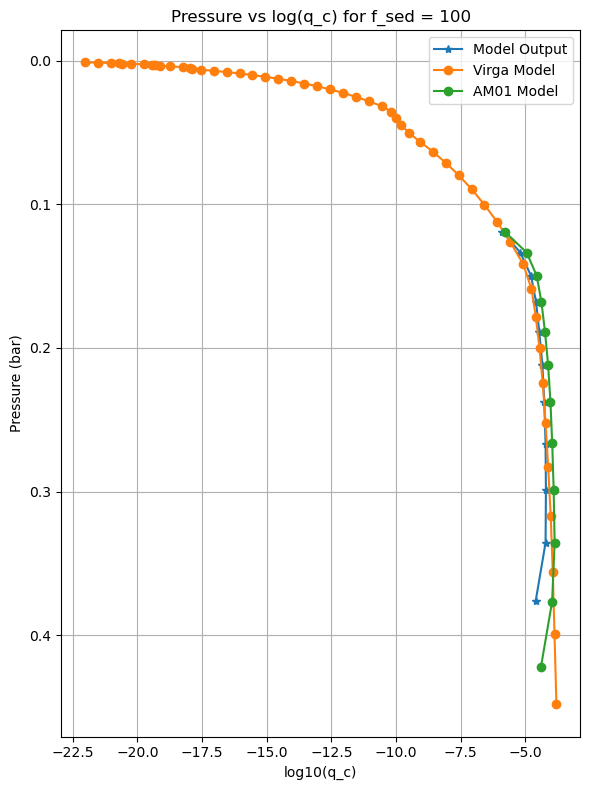

In [94]:
qc_virga = output_virga['condensate_mmr']
P_virga = output_virga['pressure']

# Limit P_virga and qc_virga arrays
P_virga = P_virga[P_virga <= 0.45]
qc_virga = qc_virga[:len(P_virga)]

plt.figure(figsize=(6, 8))
plt.plot(np.log10(qc), p_layers, marker='*',label='Model Output')
plt.plot(np.log10(qc_virga), P_virga, marker='o', label='Virga Model')
plt.plot(np.log10(voyager[:,4]), voyager[:,1]*(10**(-6)), marker='o' ,label='AM01 Model')

plt.gca().invert_yaxis()  # invert pressure axis
plt.xlabel("log10(q_c)")
plt.ylabel("Pressure (bar)")  # assuming pressure in bar (confirm units)
plt.title("Pressure vs log(q_c) for f_sed = 100")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plotting AM01 and our model
This one plots AM01 and our model

/tmp/ipykernel_6561/4177959742.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(qc), p_layers, marker='*',label='Model Output')
/tmp/ipykernel_6561/4177959742.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(voyager[:,4]), voyager[:,1]*(10**(-6)), marker='o' ,label='AM01 Model')


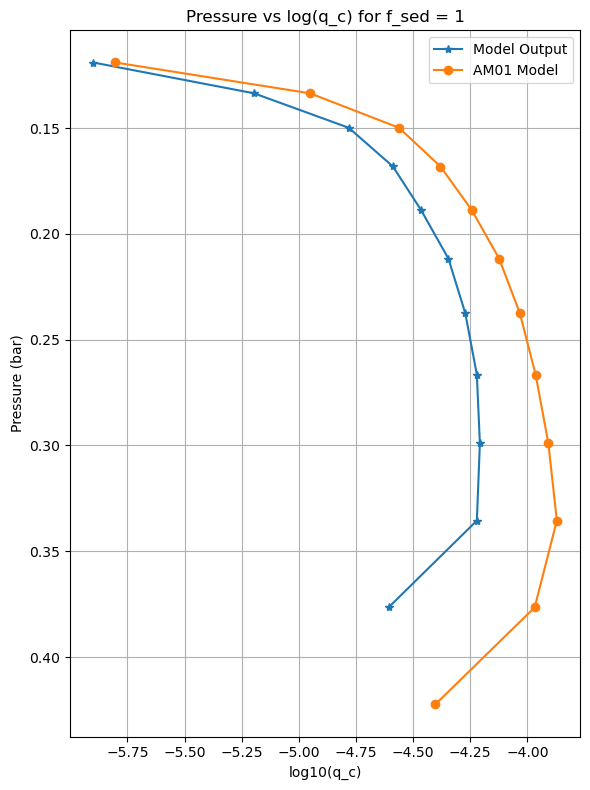

In [95]:
plt.figure(figsize=(6, 8))
plt.plot(np.log10(qc), p_layers, marker='*',label='Model Output')
plt.plot(np.log10(voyager[:,4]), voyager[:,1]*(10**(-6)), marker='o' ,label='AM01 Model')

plt.gca().invert_yaxis()  # invert pressure axis
plt.xlabel("log10(q_c)")
plt.ylabel("Pressure (bar)")  # assuming pressure in bar (confirm units)
plt.title("Pressure vs log(q_c) for f_sed = 1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Saving output as a text file
The output of running thr eddysed_lh function is saved as a txt. file

In [96]:
import numpy as np

# --- Load input profile ---
gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, \
num_layers, p_layers, t_layers, z_layers, chf, dlnp_layers, lapse_ratio = \
    read_voyager_lh("/home/sansar1/Codes/cloud_model/input/profiles/voyager.input")

# --- Run eddysed_lh model ---
f_sed = 10
sig = np.ones(num_layers)

kz, lhf, qt, qc, ndz, rg, reff, rw = eddysed_lh(
    gravity, T_eff, num_layers, sig, f_sed,
    z_layers, p_layers, t_layers, dlnp_layers,
    chf, lapse_ratio,
    gas_name="NH3", gas_mmr=1.34e-4,
    mw_atmos=2.2, rho_p=0.84
)

# --- Save to text file ---
output_filename = f"eddysed_lh_outputs_fsed{f_sed}.txt"

with open(output_filename, "w") as f:
    f.write(f"# Outputs from eddysed_lh (f_sed = {f_sed})\n")
    f.write("# Columns: P(bar), z(m), Kz(cm^2/s), LHF, qt, qc, ndz(cm^-3), rg(cm), reff(cm), rw(cm)\n")
    for i in range(num_layers):
        f.write(f"{p_layers[i]:.5e}\t{z_layers[i]:.5e}\t{kz[i]:.5e}\t{lhf[i]:.5e}\t"
                f"{qt[i]:.5e}\t{qc[i]:.5e}\t{ndz[i]:.5e}\t{rg[i]:.5e}\t"
                f"{reff[i]:.5e}\t{rw[i]:.5e}\n")

print(f"✅ Output saved to {output_filename}")


eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = 1.1196651881380962e-06
find_root(advdiff) status = 1 for NH3 at altitude = 302118.83084384224
eddysed(): condensing gas = NH3
condensate path = 7.353547635343103e-06 g/m^2
✅ Output saved to eddysed_lh_outputs_fsed10.txt


In [97]:
#print (qc)
#print (qt)

# Saving Output as a csv file
The output of running thr eddysed_lh function is saved as a csv. file

In [98]:
import numpy as np
import pandas as pd

# --- Load input profile ---
gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, \
num_layers, p_layers, t_layers, z_layers, chf, dlnp_layers, lapse_ratio = \
    read_voyager_lh("/home/sansar1/Codes/cloud_model/input/profiles/voyager.input")

# --- Run eddysed_lh model ---
f_sed = 1.0
sig = np.ones(num_layers)

kz, lhf, qt, qc, ndz, rg, reff, rw = eddysed_lh(
    gravity, T_eff, num_layers, sig, f_sed,
    z_layers, p_layers, t_layers, dlnp_layers,
    chf, lapse_ratio,
    gas_name="NH3", gas_mmr=1.34e-4,
    mw_atmos=2.2, rho_p=0.84
)

# --- Combine results into a DataFrame ---
df = pd.DataFrame({
    "P_bar": p_layers,         # pressure (bar)
    "z_m": z_layers,           # altitude (m)
    "Kz_cm2_s": kz,            # eddy diffusion coefficient (cm^2/s)
    "LHF": lhf,                # latent heat flux
    "qt": qt,                  # total mixing ratio
    "qc": qc,                  # condensate mixing ratio
    "ndz_cm3": ndz,            # number density (cm^-3)
    "rg_cm": rg,               # geometric mean radius (cm)
    "reff_cm": reff,           # effective radius (cm)
    "rw_cm": rw                # condensate radius (cm)
})

# --- Save to CSV ---
output_filename = "eddysed_lh_outputs_fsed1.csv"
df.to_csv(output_filename, index=False, float_format="%.5e")

print(f"✅ Output saved to {output_filename}")


eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = 6.15728262773864e-05
eddysed(): condensing gas = NH3
condensate path = 4.632831902787181e-05 g/m^2
✅ Output saved to eddysed_lh_outputs_fsed1.csv


# Plot of our graph vs AM01

eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = 0.00016419030864879387
eddysed(): condensing gas = NH3
condensate path = 6.59103561428859e-05 g/m^2
eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = 6.15728262773864e-05
eddysed(): condensing gas = NH3
condensate path = 4.632831902787181e-05 g/m^2
eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = 1.0262738420773064e-05
eddysed(): condensing gas = NH3
condensate path = 2.109667182733649e-05 g/m^2
eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = 1.1196651881380962e-06
find_root(advdiff) status = 1 for NH3 at altitude = 302118.83084384224
eddysed(): condensing gas = NH3
condensate path = 7.353547635343103e-06 g/m^2


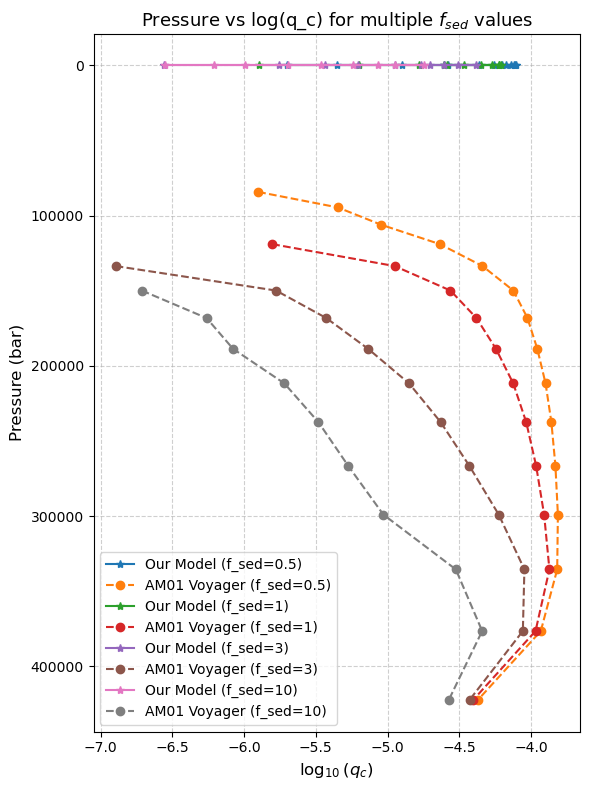

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# --- Load input profile using the voyager reader ---
gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, \
    num_layers, p_layers, t_layers, z_layers, chf, dlnp_layers, lapse_ratio = \
    read_voyager_lh("/home/sansar1/Codes/cloud_model/input/profiles/voyager.input")

def read_voyager_output(file_path):
    """Reads AM01 (Voyager) .out files, skipping first 3 header lines."""
    voyager = []
    with open(file_path, "r") as f:
        lines = f.readlines()
        for line in lines[3:]:
            parts = line.strip().split()
            # convert each part to float, handling 'E' notation
            voyager.append([float(x.replace("E", "e")) for x in parts])
    return np.array(voyager)

voyager_files = {
    0.5: "/home/sansar1/Codes/cloud_model/output/voyager_frain0.5_sig2.out",
    1: "/home/sansar1/Codes/cloud_model/output/voyager_frain1_sig2.out",
    3: "/home/sansar1/Codes/cloud_model/output/voyager_frain3_sig2.out",
    10: "/home/sansar1/Codes/cloud_model/output/voyager_frain10_sig2.out"
}


# --- Define f_sed values ---
f_sed_values = [0.5, 1, 3, 10]

# Dictionary to store qc arrays
qc_dict = {}

# --- Run the eddysed_lh model for each f_sed value ---
for i, f_sed in enumerate(f_sed_values, start=1):
    sig = np.ones(num_layers)
    kz, lhf, qt, qc, ndz, rg, reff, rw = eddysed_lh(
        gravity, T_eff, num_layers, sig, f_sed,
        z_layers, p_layers, t_layers, dlnp_layers,
        chf, lapse_ratio,
        gas_name="NH3", gas_mmr=1.34e-4,
        mw_atmos=2.2, rho_p=0.84,
    )

    # Store qc for plotting
    qc_dict[f_sed] = qc

# --- Plot all models together ---
plt.figure(figsize=(6, 8))

for f_sed in f_sed_values:
    qc = qc_dict[f_sed]

    voyager_data = read_voyager_output(voyager_files[f_sed])
    # Column convention from AM01 output: 
    # 0 = layer index?, 1 = pressure(μbar?), 4 = q_c (approximate)
    # Adjust pressure to bar if needed (e.g., 1 μbar = 1e-6 bar)
    p_voyager = voyager_data[:, 1] 
    qc_voyager = voyager_data[:, 4]

    # Avoid log10 of zero: compute log only on positive entries
    qc_plot = np.full_like(qc, np.nan, dtype=float)
    mask = qc > 0
    if np.any(mask):
        qc_plot[mask] = np.log10(qc[mask])

    qc_voy_plot = np.full_like(qc_voyager, np.nan, dtype=float)
    mask_v = qc_voyager > 0
    if np.any(mask_v):
        qc_voy_plot[mask_v] = np.log10(qc_voyager[mask_v])

    # p_layers are stored internally in cgs; convert back to bar for plotting
    p_layers_bar = p_layers 

    plt.plot(qc_plot, p_layers_bar, marker='*', label=f"Our Model (f_sed={f_sed})")
    plt.plot(qc_voy_plot, p_voyager, marker='o', linestyle='--', label=f"AM01 Voyager (f_sed={f_sed})")

# --- Formatting ---
plt.gca().invert_yaxis()
plt.xlabel(r"$\log_{10}(q_c)$", fontsize=12)
plt.ylabel("Pressure (bar)", fontsize=12)
plt.title("Pressure vs log(q_c) for multiple $f_{sed}$ values", fontsize=13)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = 0.00016419030864879387
eddysed(): condensing gas = NH3
condensate path = 6.59103561428859e-05 g/m^2
eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = 6.15728262773864e-05
eddysed(): condensing gas = NH3
condensate path = 4.632831902787181e-05 g/m^2
eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = 1.0262738420773064e-05
eddysed(): condensing gas = NH3
condensate path = 2.109667182733649e-05 g/m^2
eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = 1.1196651881380962e-06
find_root(advdiff) status = 1 for NH3 at altitude = 302118.83084384224
eddysed(): condensing gas = NH3
condensate path = 7.353547635343103e-06 g/m^2


/tmp/ipykernel_6561/527728912.py:69: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(np.log10(qc), p_layers,color=colors[f_sed], linestyle='-', label=f"Our Model ({f_sed})")
/tmp/ipykernel_6561/527728912.py:70: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(np.log10(qc_voyager), p_voyager, color=colors[f_sed], linestyle='--', label=f"AM01 ({f_sed})")


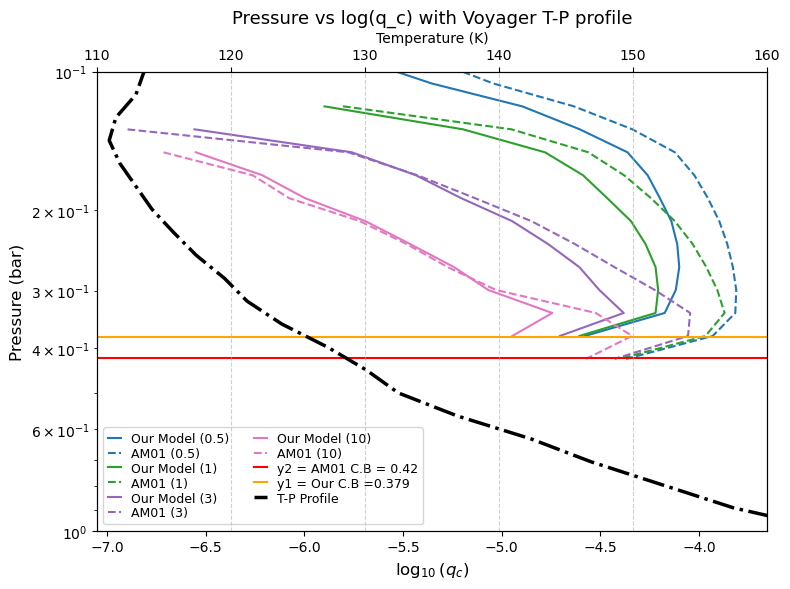

In [100]:
# --- Load input profile using the voyager reader ---
gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, \
num_layers, p_layers, t_layers, z_layers, chf, dlnp_layers, lapse_ratio = \
    read_voyager_lh("/home/sansar1/Codes/cloud_model/input/profiles/voyager.input")
def read_voyager_output(file_path):
    """Reads AM01 (Voyager) .out files, skipping first 3 header lines."""
    voyager = []
    with open(file_path, "r") as f:
        lines = f.readlines()
        for line in lines[3:]:
            parts = line.strip().split()
            # convert each part to float, handling 'E' notation
            voyager.append([float(x.replace("E", "e")) for x in parts])
    return np.array(voyager)
voyager_files = {
    0.5: "/home/sansar1/Codes/cloud_model/output/voyager_frain0.5_sig2.out",
    1: "/home/sansar1/Codes/cloud_model/output/voyager_frain1_sig2.out",
    3: "/home/sansar1/Codes/cloud_model/output/voyager_frain3_sig2.out",
    10: "/home/sansar1/Codes/cloud_model/output/voyager_frain10_sig2.out"
}


# --- Define f_sed values ---
f_sed_values = [0.5, 1, 3, 10]
colors = {
    0.5: "tab:blue",
    1:   "tab:green",
    3:   "tab:purple",
    10:  "tab:pink"
}


# Dictionary to store qc arrays
qc_dict = {}

# --- Run the eddysed_lh model for each f_sed value ---
for i, f_sed in enumerate(f_sed_values, start=1):
    sig = np.ones(num_layers)
    kz, lhf, qt, qc, ndz, rg, reff, rw = eddysed_lh(
        gravity, T_eff, num_layers, sig, f_sed,
        z_layers, p_layers, t_layers, dlnp_layers,
        chf, lapse_ratio,
        gas_name="NH3", gas_mmr=1.34e-4,
        mw_atmos=2.2, rho_p=0.84
    )

    # Store qc for plotting
    qc_dict[f_sed] = qc

for f_sed in f_sed_values:
    qc = qc_dict[f_sed]
    
    voyager_data = read_voyager_output(voyager_files[f_sed])
    # Column convention from AM01 output: 
    # 0 = layer index?, 1 = pressure(μbar?), 4 = q_c (approximate)
    # Adjust pressure to bar if needed (e.g., 1 μbar = 1e-6 bar)
    p_voyager = voyager_data[:, 1] * 1e-6
    qc_voyager = voyager_data[:, 4]
# --- Plot all models together ---
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot model vs Voyager data
for f_sed in f_sed_values:
    qc = qc_dict[f_sed]
    voyager_data = read_voyager_output(voyager_files[f_sed])
    p_voyager = voyager_data[:, 1] * 1e-6  # μbar → bar
    qc_voyager = voyager_data[:, 4]

    ax1.plot(np.log10(qc), p_layers,color=colors[f_sed], linestyle='-', label=f"Our Model ({f_sed})")
    ax1.plot(np.log10(qc_voyager), p_voyager, color=colors[f_sed], linestyle='--', label=f"AM01 ({f_sed})")

# --- Add T–P profile on top axis ---
input_file = "/home/sansar1/Codes/cloud_model/input/profiles/voyager.input"
input_data = []
with open(input_file, "r") as f:
    lines = f.readlines()
    T_eff = float(lines[0])
    gravity = float(lines[1])
    num_layer_edges = int(lines[2])
    for line in lines[4:]:
        parts = line.strip().split()
        input_data.append([float(x.replace("E", "e")) for x in parts])
input_array = np.array(input_data)
t_layer_edges = input_array[:, 0]  # Temperature (K)
p_layer_edges = input_array[:, 1]  # Pressure (bar)

# Create twin x-axis for temperature
ax2 = ax1.twiny()
ax2.plot(t_layer_edges, p_layer_edges, color='black',linestyle='-.', lw=2.5, label="T-P Profile")
ax2.set_xlabel("Temperature (K)")
ax2.grid(False)

# Give temperature axis independent limits
ax2.set_xlim(110, 160)  # adjust as needed to match your T range


# --- Formatting ---
ax1.set_yscale("log")        # Logarithmic pressure axis
ax1.invert_yaxis() 
   # Keep downward pressure orientation
ax1.set_xlabel(r"$\log_{10}(q_c)$", fontsize=12)
ax1.set_ylabel("Pressure (bar)", fontsize=12)
ax1.set_title("Pressure vs log(q_c) with Voyager T-P profile", fontsize=13)
#ax1.grid(True, which='both', linestyle='--', alpha=0.6)
ax1.axhline(y=0.42, color='red', linestyle='-', lw=1.5, label="y2 = AM01 C.B = 0.42")
ax1.axhline(y=0.379, color='orange', linestyle='-', lw=1.5, label="y1 = Our C.B =0.379")
ax1.set_ylim(1, 0.1) 
# Combine legends (for both axes)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower left")
ax1.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc="lower left",
    fontsize=9,
    labelspacing=0.15,
    handlelength=1.0,
    ncol=2
)
ax1.ticklabel_format(axis='x', style='plain')


plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Our Model vs Virga

eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = 0.00016419030864879387
eddysed(): condensing gas = NH3
condensate path = 6.59103561428859e-05 g/m^2
eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = 6.15728262773864e-05
eddysed(): condensing gas = NH3
condensate path = 4.632831902787181e-05 g/m^2
eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = 1.0262738420773064e-05
eddysed(): condensing gas = NH3
condensate path = 2.109667182733649e-05 g/m^2
eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = 1.1196651881380962e-06
find_root(advdiff) status = 1 for NH3 at altitude = 302118.83084384224
eddysed(): condensing gas = NH3
condensate path = 7.353547635343103e-06 g/m^2


/tmp/ipykernel_6561/2586868423.py:94: RuntimeWarning: divide by zero encountered in log10
  np.log10(qc_dict[f_sed]), p_layers,


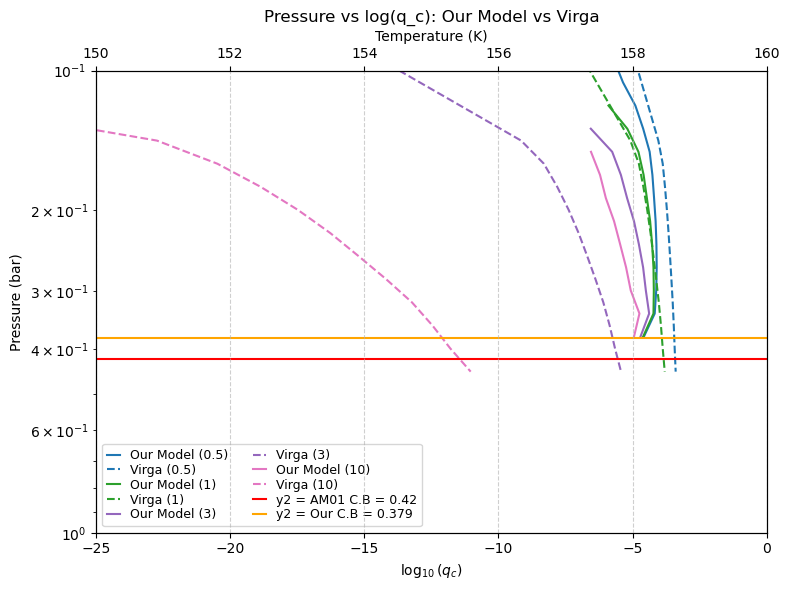

In [101]:
# --- Load input profile using the voyager reader ---
gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, \
num_layers, p_layers, t_layers, z_layers, chf, dlnp_layers, lapse_ratio = \
    read_voyager_lh("/home/sansar1/Codes/cloud_model/input/profiles/voyager.input")

import virga.justdoit as jdi
import astropy.units as u
import pandas as pd


# --- f_sed values and colors ---
f_sed_values = [0.5, 1, 3, 10]
colors = {
    0.5: "tab:blue",
    1:   "tab:green",
    3:   "tab:purple",
    10:  "tab:pink"
}

qc_dict = {}
virga_qc_dict = {}
virga_p_dict = {}

# --- RUN OUR MODEL + VIRGA MODEL ---
for f_sed in f_sed_values:

    # -------------------------
    # 1. Our Model (eddysed_lh)
    # -------------------------
    sig = np.ones(num_layers)
    kz, lhf, qt, qc, ndz, rg, reff, rw = eddysed_lh(
        gravity, T_eff, num_layers, sig, f_sed,
        z_layers, p_layers, t_layers, dlnp_layers,
        chf, lapse_ratio,
        gas_name="NH3", gas_mmr=1.34e-4,
        mw_atmos=2.2, rho_p=0.84
    )

    qc_dict[f_sed] = qc


    # -------------------------
    # 2. VIRGA MODEL
    # -------------------------
    t = t_layers
    p = p_layers
    z = z_layers
    mixl = chf * np.ones_like(t)
    kz_arr = kz

    df = pd.DataFrame({
        "temperature": t,
        "pressure": p,
        "altitude": z,
        "mixing_length": mixl,
        "kz": kz_arr,
        "chf": chf * np.ones_like(t)
    })

    atmos = jdi.Atmosphere(["NH3"], fsed=f_sed)
    cmps2 = u.cm / (u.s**2)
    atmos.gravity(gravity=gravity, gravity_unit=cmps2)
    atmos.ptk(df=df, Teff=T_eff, convective_overshoot=1/3, latent_heat=True)

    output_virga = jdi.compute(
        atmo=atmos,
        directory='/home/sansar1/Codes/cloud_model/input/optics'
    )

    qc_virga = np.array(output_virga["condensate_mmr"])
    p_virga = np.array(output_virga["pressure"])

    # Limit pressure range to ≤ 0.45 bar
    mask = p_virga <= 0.45
    p_virga = p_virga[mask]
    qc_virga = qc_virga[mask]

    virga_p_dict[f_sed] = p_virga
    virga_qc_dict[f_sed] = qc_virga



# ===============================================================
#                      PLOTTING SECTION
# ===============================================================

fig, ax1 = plt.subplots(figsize=(8, 6))

# ---------- PLOT OUR MODEL + VIRGA MODEL ----------
for f_sed in f_sed_values:

    # Our Model
    ax1.plot(
        np.log10(qc_dict[f_sed]), p_layers,
        color=colors[f_sed], linestyle='-',
        label=f"Our Model ({f_sed})"
    )

    # VIRGA Model
    ax1.plot(
        np.log10(virga_qc_dict[f_sed]), virga_p_dict[f_sed],
        color=colors[f_sed], linestyle='--',
        label=f"Virga ({f_sed})"
    )


# ---------- T–P PROFILE ----------
input_file = "/home/sansar1/Codes/cloud_model/input/profiles/voyager.input"
input_data = []
with open(input_file, "r") as f:
    lines = f.readlines()[4:]
    for line in lines:
        input_data.append([float(x.replace("E", "e")) for x in line.split()])
input_array = np.array(input_data)

t_layer_edges = input_array[:, 0]
p_layer_edges = input_array[:, 1]

ax2 = ax1.twiny()
#ax2.plot(t_layer_edges, p_layer_edges,
         #color='black', linestyle='-.', lw=2.5, label="T-P Profile")
ax2.set_xlabel("Temperature (K)")
ax2.set_xlim(150, 160)
ax1.set_xlim(-25,0)
ax2.grid(False)


# ---------- FORMATTING ----------
ax1.set_yscale("log")
ax1.invert_yaxis()
ax1.set_ylim(1, 0.1)   # restrict to 0.1–1 bar
ax1.set_xlabel(r"$\log_{10}(q_c)$")
ax1.set_ylabel("Pressure (bar)")
ax1.set_title("Pressure vs log(q_c): Our Model vs Virga")

ax1.axhline(y=0.42, color='red', lw=1.5, label="y2 = AM01 C.B = 0.42")
ax1.axhline(y=0.379, color='orange', lw=1.5, label="y2 = Our C.B = 0.379")

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2,
           loc="lower left",
           fontsize=9, labelspacing=0.15,
           handlelength=1.0, ncol=2)

# No scientific notation on x-axis
ax1.ticklabel_format(axis='x', style='plain')

plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.tight_layout()



# AM01 Vs Virga

/tmp/ipykernel_6561/1645149083.py:91: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(np.log10(qc_am), p_am, color=colors[fsed],


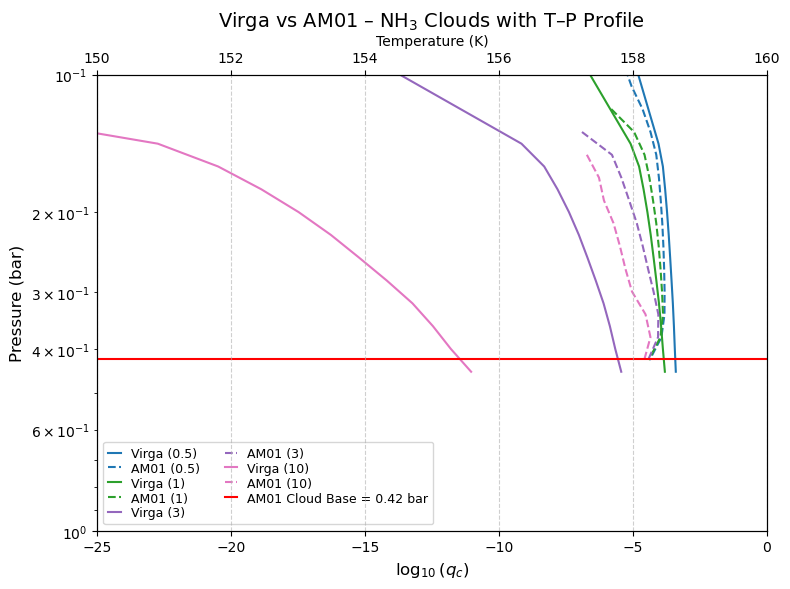

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import virga.justdoit as jdi
import astropy.units as u

# ===============================================================
#                   READ VOYAGER INPUT PROFILE
# ===============================================================
gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, \
num_layers, p_layers, t_layers, z_layers, chf, dlnp_layers, lapse_ratio = \
    read_voyager_lh("/home/sansar1/Codes/cloud_model/input/profiles/voyager.input")

# ===============================================================
#              FUNCTION: READ VOYAGER AM01 OUTPUT FILES
# ===============================================================
def read_voyager_output(file_path):
    voyager = []
    with open(file_path, "r") as f:
        lines = f.readlines()
        for line in lines[3:]:
            parts = line.strip().split()
            voyager.append([float(x.replace("E", "e")) for x in parts])
    return np.array(voyager)

# Voyager AM01 output files for each f_sed
voyager_files = {
    0.5: "/home/sansar1/Codes/cloud_model/output/voyager_frain0.5_sig2.out",
    1:   "/home/sansar1/Codes/cloud_model/output/voyager_frain1_sig2.out",
    3:   "/home/sansar1/Codes/cloud_model/output/voyager_frain3_sig2.out",
    10:  "/home/sansar1/Codes/cloud_model/output/voyager_frain10_sig2.out"
}

f_sed_values = [0.5, 1, 3, 10]

colors = {
    0.5: "tab:blue",
    1:   "tab:green",
    3:   "tab:purple",
    10:  "tab:pink"
}

# ===============================================================
#          COMPUTE VIRGA MODEL FOR ALL f_sed VALUES
# ===============================================================
virga_qc_dict = {}
virga_p_dict = {}

for fsed in f_sed_values:

    data = np.column_stack((t_layers, p_layers, z_layers,
                            np.zeros_like(t_layers),
                            np.zeros_like(t_layers),
                            chf))

    df = pd.DataFrame(data, columns=['temperature','pressure','altitude',
                                     'mixing_length','kz','chf'])

    atmos = jdi.Atmosphere(['NH3'], fsed=fsed)
    atmos.gravity(gravity=gravity, gravity_unit=u.cm/u.s**2)
    atmos.ptk(df=df, Teff=T_eff, convective_overshoot=1/3, latent_heat=True)

    output_virga = jdi.compute(atmo=atmos,
                directory='/home/sansar1/Codes/cloud_model/input/optics')

    qc_virga = np.array(output_virga['condensate_mmr'])
    P_virga = np.array(output_virga['pressure'])

    mask = P_virga <= 0.45
    virga_qc_dict[fsed] = qc_virga[mask]
    virga_p_dict[fsed]  = P_virga[mask]

# ===============================================================
#                  BEGIN PLOTTING
# ===============================================================
fig, ax1 = plt.subplots(figsize=(8, 6))

# ---- VIRGA vs AM01 plots ----
for fsed in f_sed_values:

    qc_v = virga_qc_dict[fsed]
    p_v = virga_p_dict[fsed]

    voy = read_voyager_output(voyager_files[fsed])
    p_am = voy[:, 1] * 1e-6
    qc_am = voy[:, 4]

    ax1.plot(np.log10(qc_v), p_v, color=colors[fsed],
             linestyle='-', label=f"Virga ({fsed})")

    ax1.plot(np.log10(qc_am), p_am, color=colors[fsed],
             linestyle='--', label=f"AM01 ({fsed})")

# ===============================================================
#              ADD T-P PROFILE ON TOP AXIS
# ===============================================================
input_file = "/home/sansar1/Codes/cloud_model/input/profiles/voyager.input"
input_data = []
with open(input_file, "r") as f:
    lines = f.readlines()
    Teff = float(lines[0])
    grav = float(lines[1])
    nedge = int(lines[2])
    for line in lines[4:]:
        parts = line.strip().split()
        input_data.append([float(x.replace("E","e")) for x in parts])

input_array = np.array(input_data)
T_prof = input_array[:, 0]
P_prof = input_array[:, 1]

ax2 = ax1.twiny()
#ax2.plot(T_prof, P_prof, color='black', linestyle='-.', lw=2.5,
         #label="T–P Profile")

ax2.set_xlabel("Temperature (K)")
ax2.grid(False)
ax2.set_xlim(150, 160)
ax1.set_xlim (-25,0)

# ===============================================================
#    Formatting: log pressure, cloud base lines, legend, etc.
# ===============================================================
ax1.set_yscale("log")
ax1.invert_yaxis()
ax1.set_ylim(1, 0.1)

ax1.set_xlabel(r"$\log_{10}(q_c)$", fontsize=12)
ax1.set_ylabel("Pressure (bar)", fontsize=12)
ax1.set_title("Virga vs AM01 – NH$_3$ Clouds with T–P Profile", fontsize=14)

ax1.axhline(0.42, color='red', linestyle='-', lw=1.5, label="AM01 Cloud Base = 0.42 bar")
#ax1.axhline(0.379, color='orange', linestyle='-', lw=1.5, label="Virga Cloud Base = 0.379 bar")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(lines1 + lines2,
           labels1 + labels2,
           loc="lower left",
           fontsize=9,
           labelspacing=0.15,
           handlelength=1.0,
           ncol=2)

plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [103]:
# Debug: run eddysed_lh and report NaN counts for key arrays
import numpy as np

print('Running quick diagnostic of notebook eddysed_lh')

gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, \
    num_layers, p_layers, t_layers, z_layers, chf, dlnp_layers, lapse_ratio = \
    read_voyager_lh("/home/sansar1/Codes/cloud_model/input/profiles/voyager.input")

f_sed = 1.0
sig = np.ones(num_layers)

try:
    kz_n, lhf_n, qt_n, qc_n, ndz_n, rg_n, reff_n, rw_n = eddysed_lh(
        gravity, T_eff, num_layers, sig, f_sed,
        z_layers, p_layers, t_layers, dlnp_layers,
        chf, lapse_ratio,
        gas_name="NH3", gas_mmr=1.34e-4,
        mw_atmos=2.2, rho_p=0.84
    )
except Exception as e:
    print('Error running eddysed_lh:', e)
    raise

arrays = {
    'kz': np.array(kz_n),
    'qt': np.array(qt_n),
    'qc': np.array(qc_n),
    'ndz': np.array(ndz_n),
    'rg': np.array(rg_n),
    'reff': np.array(reff_n),
    'rw': np.array(rw_n)
}

for name, arr in arrays.items():
    print(f"{name}: shape={arr.shape}, nans={np.isnan(arr).sum()}, infs={np.isinf(arr).sum()}, min={np.nanmin(arr) if arr.size else 'NA'}, max={np.nanmax(arr) if arr.size else 'NA'}")

# print a few sample entries around cloud base region
print('\nSample (first 10) qc, rg, reff, ndz:')
for i in range(min(50, len(qc_n))):
    print(i, qc_n[i], rg_n[i], reff_n[i], ndz_n[i])

# Save diagnostics to file
with open('debug_eddysed_lh_summary.txt', 'w') as fo:
    fo.write('Diagnostics for eddysed_lh\n')
    for name, arr in arrays.items():
        fo.write(f"{name}: nans={np.isnan(arr).sum()}, infs={np.isinf(arr).sum()}, min={np.nanmin(arr) if arr.size else 'NA'}, max={np.nanmax(arr) if arr.size else 'NA'}\n")

print('\nDiagnostics saved to debug_eddysed_lh_summary.txt')

Running quick diagnostic of notebook eddysed_lh
eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = 6.15728262773864e-05
eddysed(): condensing gas = NH3
condensate path = 4.632831902787181e-05 g/m^2
kz: shape=(312,), nans=0, infs=0, min=0.0, max=269663327385.13513
qt: shape=(312,), nans=0, infs=0, min=0.0, max=0.000134
qc: shape=(312,), nans=0, infs=0, min=0.0, max=6.198969517533058e-05
ndz: shape=(312,), nans=0, infs=0, min=0.0, max=28.152965534395083
rg: shape=(312,), nans=0, infs=0, min=0.0, max=0.0002457852418828806
reff: shape=(312,), nans=0, infs=0, min=0.0, max=0.0002457852418828806
rw: shape=(312,), nans=0, infs=0, min=0.0, max=0.0002457852418828806

Sample (first 10) qc, rg, reff, ndz:
0 0.0 0.0 0.0 0.0
1 0.0 0.0 0.0 0.0
2 0.0 0.0 0.0 0.0
3 0.0 0.0 0.0 0.0
4 0.0 0.0 0.0 0.0
5 0.0 0.0 0.0 0.0
6 0.0 0.0 0.0 0.0
7 0.0 0.0 0.0 0.0
8 0.0 0.0 0.0 0.0
9 0.0 0.0 0.0 0.0
10 0.0 0.0 0.0 0.0
11 0.0 0.0 0.0 0.0
12 0.0 0.0 0.0 0.0
13 0.0 0.0 0.0 0.0
14 0.0 0.0 0

Running eddysed_lh for f_sed values: [0.5, 1, 3, 10]
eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = 0.0002654653222693542
eddysed(): condensing gas = NH3
condensate path = 6.59103561428859e-05 g/m^2
f_sed=0.5: qc NaNs=0, rg NaNs=0, reff NaNs=0
eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = 9.955161585693887e-05
eddysed(): condensing gas = NH3
condensate path = 4.632831902787181e-05 g/m^2
f_sed=1: qc NaNs=0, rg NaNs=0, reff NaNs=0
eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = 1.6593058368189227e-05
eddysed(): condensing gas = NH3
condensate path = 2.109667182733649e-05 g/m^2
f_sed=3: qc NaNs=0, rg NaNs=0, reff NaNs=0
eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = 1.8103162579946122e-06
find_root(advdiff) status = 1 for NH3 at altitude = 302118.83084384224
eddysed(): condensing gas = NH3
condensate path = 7.353547635343103e-06 g/m^2
f_sed=10: qc NaNs=0, rg 

/tmp/ipykernel_6561/1696476322.py:79: RuntimeWarning: divide by zero encountered in log10
  qc_safe_log10 = np.where((qc > 0) & np.isfinite(qc), np.log10(qc), np.nan)
/tmp/ipykernel_6561/1696476322.py:92: RuntimeWarning: divide by zero encountered in log10
  qc_voyager_safe = np.where((qc_voyager > 0) & np.isfinite(qc_voyager), np.log10(qc_voyager), np.nan)


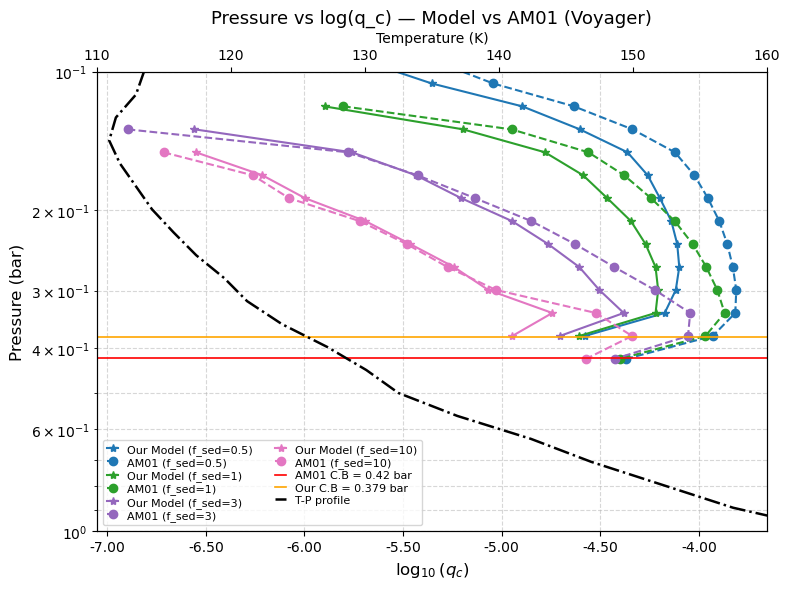

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

# --- Read profile (your reader must exist in the session) ---
gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, \
    num_layers, p_layers, t_layers, z_layers, chf, dlnp_layers, lapse_ratio = \
    read_voyager_lh("/home/sansar1/Codes/cloud_model/input/profiles/voyager.input")

# --- Convert pressures to cgs (dyne/cm^2) for model calculations ---
# read_voyager_lh returns p_layers in bar (based on your earlier code).
p_layers_cgs = p_layers   # 1 bar = 1e6 dyne/cm^2

# --- Files for AM01 (Voyager) outputs (one per f_sed) ---
voyager_files = {
    0.5: "/home/sansar1/Codes/cloud_model/output/voyager_frain0.5_sig2.out",
    1:   "/home/sansar1/Codes/cloud_model/output/voyager_frain1_sig2.out",
    3:   "/home/sansar1/Codes/cloud_model/output/voyager_frain3_sig2.out",
    10:  "/home/sansar1/Codes/cloud_model/output/voyager_frain10_sig2.out"
}

def read_voyager_output(file_path):
    """Read AM01 .out files, skipping first 3 header lines. Return numpy array."""
    rows = []
    with open(file_path, "r") as fh:
        lines = fh.readlines()
    for line in lines[3:]:
        parts = line.strip().split()
        if not parts:
            continue
        rows.append([float(x.replace("E", "e")) for x in parts])
    return np.array(rows)

# --- Settings ---
f_sed_values = [0.5, 1, 3, 10]
colors = {0.5: "tab:blue", 1: "tab:green", 3: "tab:purple", 10: "tab:pink"}

# --- Run eddysed_lh for each f_sed and collect outputs ---
qc_dict = {}
model_outputs = {}
reff_dict = {}
rg_dict = {}

print("Running eddysed_lh for f_sed values:", f_sed_values)
for f_sed in f_sed_values:
    sig = 2.0 *np.ones(num_layers)
    try:
        kz,lhf, qt, qc, ndz, rg, reff, rw = eddysed_lh(
            gravity, T_eff, num_layers, sig, f_sed,
            z_layers, p_layers_cgs, t_layers, dlnp_layers,
            chf, lapse_ratio,
            gas_name="NH3", gas_mmr=1.34e-4,
            mw_atmos=2.2, rho_p=0.84
        )
    except Exception as e:
        print(f"ERROR running eddysed_lh for f_sed={f_sed}: {e}")
        raise

    # Store arrays
    qc = np.asarray(qc)
    rg = np.asarray(rg)
    reff = np.asarray(reff)
    ndz = np.asarray(ndz)
    # diagnostics
    print(f"f_sed={f_sed}: qc NaNs={np.isnan(qc).sum()}, rg NaNs={np.isnan(rg).sum()}, reff NaNs={np.isnan(reff).sum()}")

    qc_dict[f_sed] = qc
    reff_dict[f_sed] = reff
    rg_dict[f_sed] = rg
    model_outputs[f_sed] = dict(kz=kz, lhf=lhf, qt=qt, qc=qc, ndz=ndz, rg=rg, reff=reff, rw=rw)

# --- Prepare plot ---
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot model results and AM01 outputs
for f_sed in f_sed_values:
    qc = qc_dict[f_sed]
    # avoid log10(0) and negative values -> set to NaN so matplotlib skips them
    qc_safe_log10 = np.where((qc > 0) & np.isfinite(qc), np.log10(qc), np.nan)

    # plot our model: x = log10(qc), y = pressure in bar (for plotting)
    p_bar = p_layers_cgs 
    ax1.plot(qc_safe_log10, p_bar, marker='*', color=colors[f_sed], linestyle='-', label=f"Our Model (f_sed={f_sed})")

    # read and plot Voyager AM01 output for the same f_sed
    try:
        voyager_data = read_voyager_output(voyager_files[f_sed])
        # AM01 output column convention: index 1 is pressure in microbar (µbar) in your earlier usage
        # convert their column 1 (µbar) to bar by *1e-6; if different, adjust accordingly.
        p_voyager_bar = voyager_data[:, 1] * 1e-6
        qc_voyager = voyager_data[:, 4]
        qc_voyager_safe = np.where((qc_voyager > 0) & np.isfinite(qc_voyager), np.log10(qc_voyager), np.nan)
        ax1.plot(qc_voyager_safe, p_voyager_bar, marker='o', linestyle='--', color=colors[f_sed], label=f"AM01 (f_sed={f_sed})")
    except FileNotFoundError:
        print(f"Voyager output file not found for f_sed={f_sed}: {voyager_files[f_sed]}")
    except Exception as e:
        print(f"Error reading Voyager file for f_sed={f_sed}: {e}")

# --- Add T–P profile on twin x-axis (uses original input edges that are in bar) ---
input_file = "/home/sansar1/Codes/cloud_model/input/profiles/voyager.input"
input_data = []
with open(input_file, "r") as f:
    lines = f.readlines()
    # header lines
    T_eff_in = float(lines[0])
    gravity_in = float(lines[1])
    num_layer_edges_in = int(lines[2])
    for line in lines[4:]:
        parts = line.strip().split()
        if not parts:
            continue
        input_data.append([float(x.replace("E", "e")) for x in parts])
input_array = np.array(input_data)
t_layer_edges = input_array[:, 0]  # Temperature (K)
p_layer_edges_plot = input_array[:, 1]  # Pressure (bar) as in file

ax2 = ax1.twiny()
ax2.plot(t_layer_edges, p_layer_edges_plot, color='black', linestyle='-.', lw=1.8, label="T-P profile")
ax2.set_xlabel("Temperature (K)")
ax2.grid(False)
# align twin axis to same pressure limits
  # no change, but keep it explicit
ax2.set_xlim(110, 160) 
# --- Axis formatting and labels ---
ax1.set_yscale("log")
ax1.invert_yaxis()             # pressure increases downward (as in typical PT plots)
ax1.set_ylim(1.0, 0.1)         # from 1 bar down to 0.1 bar (top of plot)
ax1.set_xlabel(r"$\log_{10}(q_c)$", fontsize=12)
ax1.set_ylabel("Pressure (bar)", fontsize=12)
ax1.set_title("Pressure vs log(q_c) — Model vs AM01 (Voyager)", fontsize=13)

# draw horizontal lines for cloud-base references (if you want)
ax1.axhline(y=0.42, color='red', linestyle='-', lw=1.2, label="AM01 C.B = 0.42 bar")
ax1.axhline(y=0.379, color='orange', linestyle='-', lw=1.2, label="Our C.B = 0.379 bar")

# Combine legends from both axes, make it compact and small
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower left",
           fontsize=8, labelspacing=0.2, handlelength=1.0, ncol=2)

# format x-axis numbers to plain decimals (avoid 6e-1 style)
ax1.xaxis.set_major_formatter(ScalarFormatter())
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# grid and layout
ax1.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [109]:
import pandas as pd
import os

save_dir = "/home/sansar1/Codes/cloud_model/output/csv/"
os.makedirs(save_dir, exist_ok=True)

for f_sed in f_sed_values:

    out = model_outputs[f_sed]   # stored from eddysed_lh loop

    df = pd.DataFrame({
        "pressure_bar": p_layers_cgs / 1e6,
        "pressure_cgs": p_layers_cgs,
        "temperature_K": t_layers,
        "altitude_cm": z_layers,

        "qc": out["qc"],
        "qt": out["qt"],
        "rg_cm": out["rg"],
        "reff_cm": out["reff"],
        "rw_cm": out["rw"],
        "ndz_cm^-2": out["ndz"],
        "kz_cm2_s": out["kz"],

        
    })

    filename = f"cloud_profile_fsed{f_sed}.csv"
    filepath = os.path.join(save_dir, filename)
    df.to_csv(filepath, index=False)

    print(f"Saved: {filepath}")


Saved: /home/sansar1/Codes/cloud_model/output/csv/cloud_profile_fsed0.5.csv
Saved: /home/sansar1/Codes/cloud_model/output/csv/cloud_profile_fsed1.csv
Saved: /home/sansar1/Codes/cloud_model/output/csv/cloud_profile_fsed3.csv
Saved: /home/sansar1/Codes/cloud_model/output/csv/cloud_profile_fsed10.csv


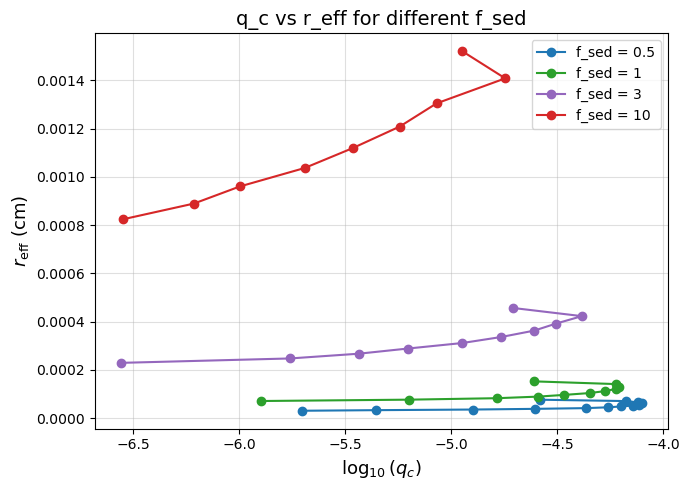

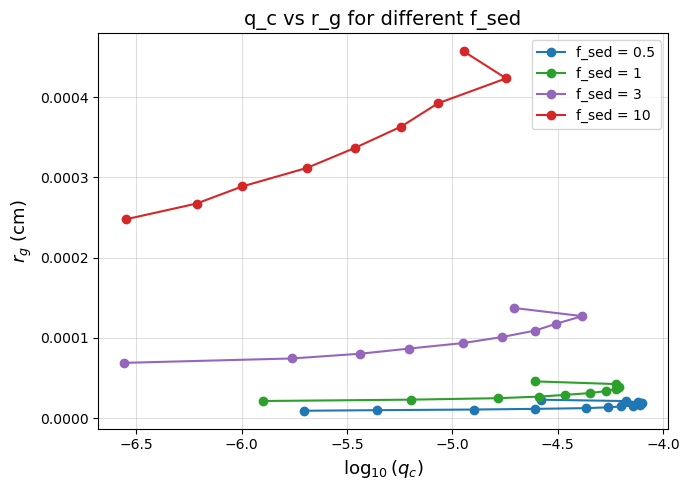

In [110]:
import numpy as np
import matplotlib.pyplot as plt

# f_sed values and colors
f_sed_values = [0.5, 1, 3, 10]
colors = {0.5:"tab:blue", 1:"tab:green", 3:"tab:purple", 10:"tab:red"}

# ------------------------------------
# PLOT 1 : q_c vs r_eff
# ------------------------------------
plt.figure(figsize=(7, 5))

for f_sed in f_sed_values:
    qc   = qc_dict[f_sed]
    reff = reff_dict[f_sed]   # <= you already compute/store these arrays

    qc_safe = np.where(qc > 0, qc, np.nan)
    plt.plot(np.log10(qc_safe), reff,
             marker='o', linestyle='-', color=colors[f_sed],
             label=f"f_sed = {f_sed}")

plt.xlabel(r"$\log_{10}(q_c)$", fontsize=13)
plt.ylabel(r"$r_{\mathrm{eff}}$ (cm)", fontsize=13)
plt.title("q_c vs r_eff for different f_sed", fontsize=14)
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


# ------------------------------------
# PLOT 2 : q_c vs r_g
# ------------------------------------
plt.figure(figsize=(7, 5))

for f_sed in f_sed_values:
    qc = qc_dict[f_sed]
    rg = rg_dict[f_sed]

    qc_safe = np.where(qc > 0, qc, np.nan)
    plt.plot(np.log10(qc_safe), rg,
             marker='o', linestyle='-', color=colors[f_sed],
             label=f"f_sed = {f_sed}")

plt.xlabel(r"$\log_{10}(q_c)$", fontsize=13)
plt.ylabel(r"$r_g$ (cm)", fontsize=13)
plt.title("q_c vs r_g for different f_sed", fontsize=14)
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()
